# ОПИСАНИЕ ЗАДАЧИ

Данные:
- чековые данные (transactions.parquet, для чтения через pandas дополнительно нужно установить библиотеку pyarrow)
- справочник товаров (materials.csv)
- справочник магазинов (plants.csv)
- справочник клиентов (clients.csv)
Более подробное описание данных дано в файле Data Description.

Цель: 
1) проанализировать данные и определить оптимальную методологию определения отточных клиентов
2) разработать модель вероятности оттока клиентов по выбранной вами методологии
3) дать интерпретацию разработанной модели, ответить на вопросы: какие признаки наиболее влияют на отток клиентов

# ЧАСТЬ 2. EDA

### Загрузка библиотек

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import pickle
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import gc
from statistics import mode

sns.set_style("whitegrid")
pd.set_option('display.max_rows', 500)
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")

### Полезные функции

In [3]:
def del_vars(vars_to_del=['tmp', 'tmp2', 'tmp3' 'result']):
    for var in vars_to_del:
        if var in globals():
            del globals()[str(var)]
    gc.collect()

# 1. Загрузка данных

In [4]:
workdir = str(Path().absolute())

In [5]:
transactions = pd.read_pickle(workdir+'/data/transactions.pkl')
clients = pd.read_pickle(workdir+'/data/clients.pkl')
materials = pd.read_pickle(workdir+'/data/materials.pkl')
plants = pd.read_pickle(workdir+'/data/plants.pkl')

Посмотрим на данные.

In [6]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32094659 entries, 0 to 32109413
Data columns (total 10 columns):
chq_date        datetime64[ns]
chq_position    int32
sales_count     float16
sales_sum       float32
is_promo        bool
client_id       int32
material        int32
plant           int16
chq_id          int32
price           float32
dtypes: bool(1), datetime64[ns](1), float16(1), float32(2), int16(1), int32(4)
memory usage: 1.3 GB


In [7]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99995 entries, 0 to 99994
Data columns (total 4 columns):
gender       99995 non-null int8
birthyear    99995 non-null int32
client_id    99995 non-null int32
city         99995 non-null int8
dtypes: int32(2), int8(2)
memory usage: 1.7 MB


In [8]:
materials.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105609 entries, 0 to 105608
Data columns (total 8 columns):
hier_level_1        105609 non-null int8
hier_level_2        105609 non-null int8
hier_level_3        105609 non-null int16
hier_level_4        105609 non-null int16
vendor              105609 non-null int16
is_private_label    105609 non-null bool
is_alco             105609 non-null bool
material            105609 non-null int32
dtypes: bool(2), int16(3), int32(1), int8(2)
memory usage: 2.2 MB


In [9]:
plants.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388 entries, 0 to 387
Data columns (total 3 columns):
plant_type    388 non-null int8
plant         388 non-null int16
city          388 non-null int8
dtypes: int16(1), int8(2)
memory usage: 4.5 KB


In [10]:
print(80*'*')
print('transactions:')
display(transactions.head())

print(80*'*')
print('clients:')
display(clients.head())

print(80*'*')
print('materials:')
display(materials.head())

print(80*'*')
print('plants:')
display(plants.head())

********************************************************************************
transactions:


,chq_date,chq_position,sales_count,sales_sum,is_promo,client_id,material,plant,chq_id,price
0,2016-11-01,4,2.0,146.979996,False,56437,14213,179,2390608,73.489998
1,2016-11-01,3,1.0,249.990005,True,56437,7629,179,2390608,249.990005
2,2016-11-01,12,1.0,47.990002,True,56437,7264,179,2390608,47.990002
3,2016-11-01,13,1.0,47.990002,True,56437,7264,179,2390608,47.990002
4,2016-11-01,11,2.0,53.980000,True,56437,35784,179,2390608,26.990000


********************************************************************************
clients:


,gender,birthyear,client_id,city
0,2,1990,10144,1
1,1,1969,61042,1
2,2,1976,83456,1
3,1,1966,7725,0
4,1,1988,12977,1


********************************************************************************
materials:


,hier_level_1,hier_level_2,hier_level_3,hier_level_4,vendor,is_private_label,is_alco,material
0,1,56,250,1220,551,False,False,21972
1,1,56,250,1748,2519,False,False,79310
2,1,56,250,1070,2519,False,False,99398
3,1,56,291,580,2673,False,False,21754
4,1,56,291,580,2673,False,False,38468


********************************************************************************
plants:


,plant_type,plant,city
0,0,215,2
1,0,211,2
2,0,252,2
3,0,18,2
4,0,110,2


# 2. EDA

### Объединение всех данных в полный датасет

Для анализа объединим все данные в единый датасет чековых транзакций/позиций. Следует учесть, что город клиента может отличаться от города, где была произведена транзакция.

In [11]:
full = transactions.merge(clients.rename(columns={'city':'client_city'}), how='left', on='client_id')\
                   .merge(materials, how='left', on='material')\
                   .merge(plants.rename(columns={'city':'plant_city'}), how='left', on='plant')

In [12]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32094659 entries, 0 to 32094658
Data columns (total 22 columns):
chq_date            datetime64[ns]
chq_position        int32
sales_count         float16
sales_sum           float32
is_promo            bool
client_id           int32
material            int32
plant               int16
chq_id              int32
price               float32
gender              int8
birthyear           int32
client_city         int8
hier_level_1        int8
hier_level_2        int8
hier_level_3        int16
hier_level_4        int16
vendor              int16
is_private_label    bool
is_alco             bool
plant_type          int8
plant_city          int8
dtypes: bool(3), datetime64[ns](1), float16(1), float32(2), int16(4), int32(5), int8(6)
memory usage: 1.9 GB


Сделаем базовую проверку полноты объединенных данных.

In [13]:
transactions.shape

(32094659, 10)

In [14]:
full.shape

(32094659, 22)

In [15]:
full.isnull().sum()

chq_date            0
chq_position        0
sales_count         0
sales_sum           0
is_promo            0
client_id           0
material            0
plant               0
chq_id              0
price               0
gender              0
birthyear           0
client_city         0
hier_level_1        0
hier_level_2        0
hier_level_3        0
hier_level_4        0
vendor              0
is_private_label    0
is_alco             0
plant_type          0
plant_city          0
dtype: int64

### Общие количественные показатели

Для начала посмотрим на общие количественные показатели в чековых данных:

In [16]:
print(f'Клиентов:       {full.client_id.nunique()} уникальных ({clients.shape[0]} в данных)')
print(f'Городов:        {full.plant_city.nunique()}')
print(f'Магазинов:      {full.plant.nunique()} уникальных ({plants.shape[0]} в данных)')
print(f'Транзакций:     {full.shape[0]}')
print(f'Чеков:          {full.chq_id.nunique()}')
print(f'Производителей: {full.vendor.nunique()}')
print(f'Товаров:        {full.material.nunique()} уникальных ({materials.shape[0]} в данных)')
print('-'*40)
print(f'Начальная дата: {full.chq_date.min()}')
print(f'Конечная дата:  {full.chq_date.max()}')

Клиентов:       99995 уникальных (99995 в данных)
Городов:        3
Магазинов:      388 уникальных (388 в данных)
Транзакций:     32094659
Чеков:          2964132
Производителей: 4185
Товаров:        105608 уникальных (105609 в данных)
----------------------------------------
Начальная дата: 2016-10-04 00:00:00
Конечная дата:  2017-10-04 00:00:00


* Уникальных товаров на 1 меньше, чем записей по ним
* Данные собраны за период 1 год

## 2.1. Временной признак chq_date 

In [17]:
print(f'Число месяца у первого дня: {full.chq_date.min().day}')
print(f'Число месяца последнего дня: {full.chq_date.max().day}')
print(f'День недели у первого дня: {full.chq_date.min().weekday()}')

print(f'День недели у последнего дня: {full.chq_date.max().weekday()}')

Число месяца у первого дня: 4
Число месяца последнего дня: 4
День недели у первого дня: 1
День недели у последнего дня: 2


Данные начинаются и заканчиваются неравномерно. Наблюдения в первом месяце начинаются с 4 числа. А последний месяц содержит всего 4 дня.
В рамках еженедельных периодов первая неделя начинается со вторника и последняя заканчивается средой.

Посмотрим на изменение общей суммы покупок и среднего чека в недельных периодах по всей выборке и на примере некоторых магазинов.

In [18]:
best_plant = full.groupby('plant')['sales_sum']\
                    .sum()\
                    .reset_index()\
                    .sort_values(by='sales_sum', ascending=False)\
                    .iloc[0]['plant']
not_best_plant = full.groupby('plant')['sales_sum']\
                    .sum()\
                    .reset_index()\
                    .sort_values(by='sales_sum', ascending=False)\
                    .iloc[49]['plant']

print(f'Самый популярный магазин: {best_plant}')
print(f'50-й популярный магазин: {not_best_plant}')

Самый популярный магазин: 215.0
50-й популярный магазин: 279.0


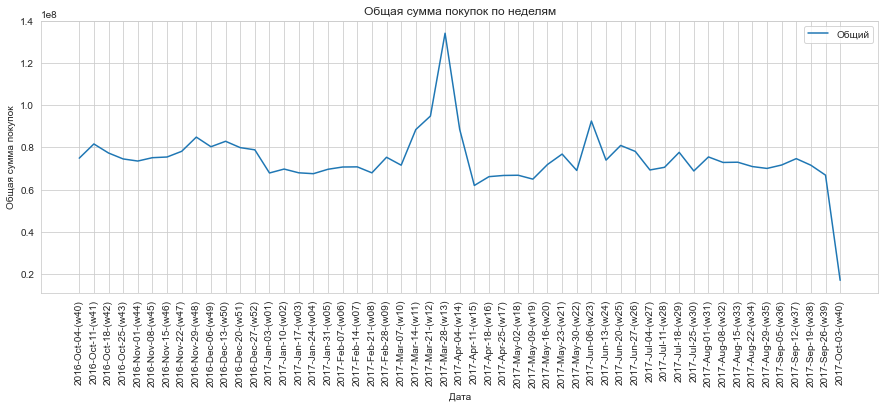

In [19]:
plt.figure(figsize=(15,5))

# Данные и график общей выборки
result = full.groupby([pd.Grouper(key='chq_date', freq='7D')])['sales_sum']\
                .sum()\
                .rename('sum_per_week')\
                .reset_index()\
                .sort_values('chq_date')
result['chq_date'] = pd.to_datetime(result['chq_date'])
g = sns.lineplot(y='sum_per_week', x='chq_date', data=result, label='Общий')

g.set_title("Общая сумма покупок по неделям")
g.set_xlabel('Дата')
g.set_ylabel('Общая сумма покупок')
g.set(xticks=result['chq_date'].values)
g.set_xticklabels(result['chq_date'].values, rotation=90)
g.xaxis.set_major_formatter(DateFormatter("%Y-%b-%d-(w%W)"))
plt.show()
del_vars()

Из графика видно, что имеется необъяснимый всплекс покупательской активности в марто-апрельские недели. И небольшой всплеск - в 23 неделю (июнь).

Посмотрим на активность покупателей в рамках некоторых магазинов.

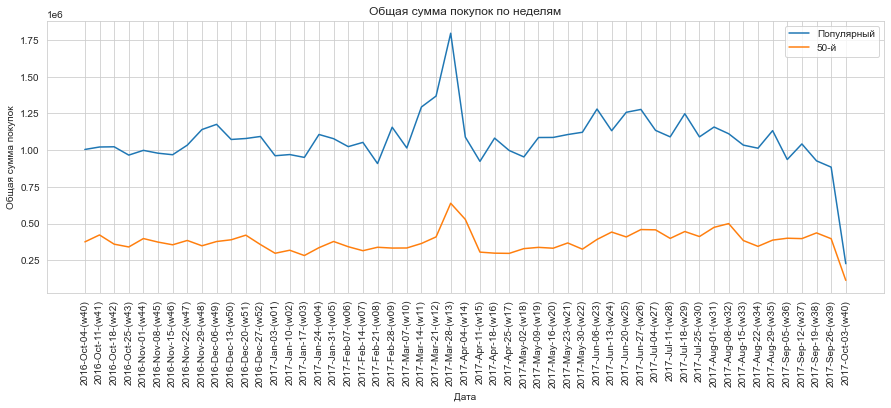

In [20]:
plt.figure(figsize=(15,5))
# Данные и график популярного магазина
tmp2 = full[full.plant == best_plant]
result = tmp2.groupby([pd.Grouper(key='chq_date', freq='7D')])['sales_sum']\
                .sum()\
                .rename('sum_per_week')\
                .reset_index()\
                .sort_values('chq_date')
result['chq_date'] = pd.to_datetime(result['chq_date'])
g = sns.lineplot(y='sum_per_week', x='chq_date', data=result, label='Популярный')

# Данные и график 50-го по популярности магазина
tmp2 = full[full.plant == not_best_plant]
result = tmp2.groupby([pd.Grouper(key='chq_date', freq='7D')])['sales_sum']\
                .sum()\
                .rename('sum_per_week')\
                .reset_index()\
                .sort_values('chq_date')
result['chq_date'] = pd.to_datetime(result['chq_date'])
g = sns.lineplot(y='sum_per_week', x='chq_date', data=result, label='50-й')

g.set_title("Общая сумма покупок по неделям")
g.set_xlabel('Дата')
g.set_ylabel('Общая сумма покупок')
g.set(xticks=result['chq_date'].values)
g.set_xticklabels(result['chq_date'].values, rotation=90)
g.xaxis.set_major_formatter(DateFormatter("%Y-%b-%d-(w%W)"))
plt.show()
del_vars()

В рамках отдельных магазинов всплеск активности в аномальные недели уже не такой ярко выраженный. И больше сглаживается в менее популярном магазине. Но аномальная активность в марте-апреле остается необъяснимой.

Посмотрим на еженедельное изменение среднего чека в рамках всей выборки, популярного магазина, и 50-го популярного магазина.  

In [21]:
def print_chk():
    print('    Минимальный был на неделе {}: {:.2f}'.format(
            result[result.chq_mean == result.chq_mean.min()].iloc[0]['chq_date'].strftime("%Y-%b-%d-(w%W)"),
            result[result.chq_mean == result.chq_mean.min()].iloc[0]['chq_mean'],
                                                       ))
    print('    Максимальный был на неделе {}: {:.2f}'.format(
            result[result.chq_mean == result.chq_mean.max()].iloc[0]['chq_date'].strftime("%Y-%b-%d-(w%W)"),
            result[result.chq_mean == result.chq_mean.max()].iloc[0]['chq_mean'],
                                                       ))

Средний чек общий:
    Минимальный был на неделе 2017-Jan-03-(w01): 1169.60
    Максимальный был на неделе 2017-Mar-28-(w13): 1696.80
Cредний чек популярного магазина:
    Минимальный был на неделе 2017-Feb-21-(w08): 1377.04
    Максимальный был на неделе 2017-Jul-04-(w27): 2066.90
Cредний чек 50-популярного магазина:
    Минимальный был на неделе 2016-Nov-29-(w48): 1263.28
    Максимальный был на неделе 2017-Jun-27-(w26): 2077.75


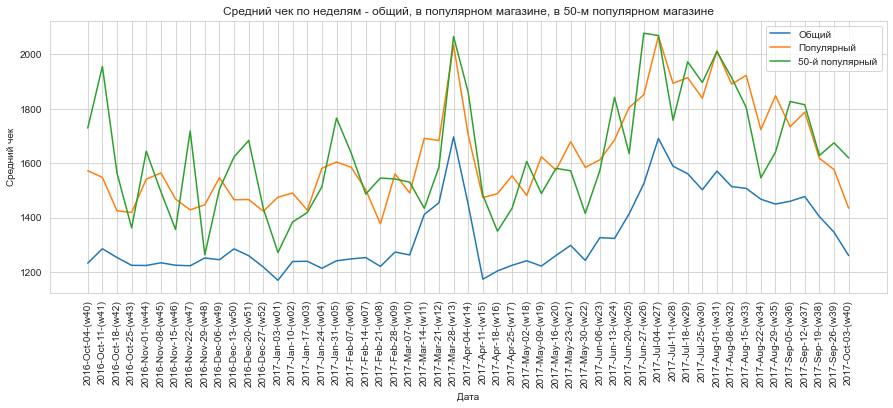

In [22]:
plt.figure(figsize=(15,5))

tmp = full.groupby(['chq_id', 'chq_date','plant'])['sales_sum'].sum().reset_index()
result = tmp.groupby([pd.Grouper(key='chq_date', freq='7D')])['sales_sum']\
                .mean()\
                .rename('chq_mean')\
                .reset_index()\
                .sort_values('chq_date')
print('Средний чек общий:')
print_chk()
result['chq_date'] = pd.to_datetime(result['chq_date'])
g = sns.lineplot(y='chq_mean', x='chq_date', data=result, label='Общий')

tmp2 = tmp[tmp.plant == best_plant]
result = tmp2.groupby([pd.Grouper(key='chq_date', freq='7D')])['sales_sum']\
                .mean()\
                .rename('chq_mean')\
                .reset_index()\
                .sort_values('chq_date')
print('Cредний чек популярного магазина:')
print_chk()
result['chq_date'] = pd.to_datetime(result['chq_date'])
g = sns.lineplot(y='chq_mean', x='chq_date', data=result, label='Популярный')


tmp2 = tmp[tmp.plant == not_best_plant]
result = tmp2.groupby([pd.Grouper(key='chq_date', freq='7D')])['sales_sum']\
                .mean()\
                .rename('chq_mean')\
                .reset_index()\
                .sort_values('chq_date')
print('Cредний чек 50-популярного магазина:')
print_chk()
result['chq_date'] = pd.to_datetime(result['chq_date'])
g = sns.lineplot(y='chq_mean', x='chq_date', data=result, label='50-й популярный')

g.set_title("Средний чек по неделям - общий, в популярном магазине, в 50-м популярном магазине")
g.set_xlabel('Дата')
g.set_ylabel('Средний чек')
g.set(xticks=result['chq_date'].values)
g.set_xticklabels(result['chq_date'].values, rotation=90)
g.xaxis.set_major_formatter(DateFormatter("%Y-%b-%d-(w%W)"))
plt.show()
del_vars()

Из графиков следует, что средний чек также увеличивается в марто-апрельские недели как в общей статистике, так и в рамках отдельных магазинов. Однако стало заметно, что к июлю средний чек начинает увеличиваться, и затем спадает к октябрю. Причем в непопулярном магазине статистика по среднему чеку изменяется более хаотично. Это объяснимо меньшим количеством данных (покупок).

_Выводы:_
* _В марте-апреле клиенты потратили больше денег._
* _C марта по апрель и с июля по сентябрь клиенты совершают покупки на большую сумму, чем в остальные месяцы._
* _Данные за другие годы отсутствуют. Поэтому нельзя выяснить, что данные активности являются сезонным трендом._
* _Общий средний чек изменяется в диапазоне 1169-1696. Разницу между минимальным и максимальным значением нельзя назвать существенной._ 

## 2.2. Территориальные признаки

Территориальные данные представлены признаками:

    plant
    plant_city
    client_city

Уровень жизни клиентов различается в Москве, СПб и других городах. Также уровень жизни клиентов различается в разных районах города, где расположены магазины. Поэтому территориальные признаки должны влиять на средний чек клиентов и категории покупаемых товаров.

### Признак client_city (город, в котором клиент совершает большинство покупок)

Вероятно, признак client_city заполнялся клиентами, поэтому не может претендовать на достоверность. К тому же эта информация не имеет ценности в данном исследовании. Признак plant дает более точечную информацию о территориальных активностях клиента.

Для начала проверим достоверность этих данных. Посмотрим сколько клиентов указали один город, но делали все покупки в других городах.

In [23]:
tmp = full[['client_id', 'client_city', 'plant_city']].drop_duplicates()
tmp['same_city'] = tmp['client_city'] == tmp['plant_city']
result = tmp.pivot_table(values='same_city', index=['client_id', 'client_city'], columns='plant_city', aggfunc='first')
print('Доля клиентов, указавших один город, но делавших все покупки в других городах: {:.3f}'\
      .format(result[(result[0]!=True) & (result[1]!=True) & (result[2]!=True)].shape[0]/result.shape[0]))
del_vars()

Доля клиентов, указавших один город, но делавших все покупки в других городах: 0.035


Действительно, более 3 процентов клиентов указали город, в котором не совершали покупок. Есть вероятность, что некоторые клиенты заполнили эти данные некорректно. 

_Выводы:_ 
* _Удаление данного признака не повлияет на исследование, и исключит вероятность использования неточных данных._

In [24]:
full = full.drop(columns='client_city')

### Признак plant_city (город расположения магазина)

Признак plant_city также имеет смысл удалить. Так как признак plant дает более точечную информацию о территориальных активностях клиента. Но для начала посмотрим на информацию о соотношении клиентов, совершивших покупки в одном и более городах.

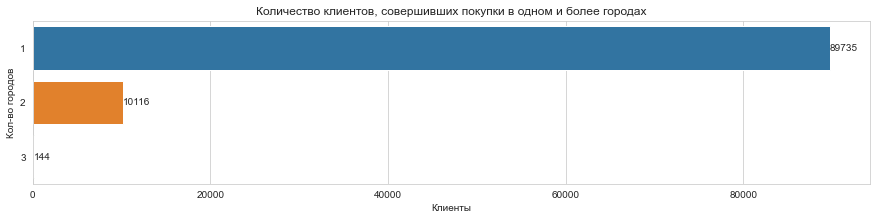

In [25]:
tmp = full.groupby(['client_id'])['plant_city'].nunique().rename('cities_count').reset_index()
result = tmp.groupby('cities_count')['client_id'].size().rename('clients_count').reset_index()

plt.figure(figsize=(15,3))
g = sns.barplot(y="cities_count", x="clients_count", data=result, orient='h')
g.set_title("Количество клиентов, совершивших покупки в одном и более городах")
g.set_xlabel('Клиенты')
g.set_ylabel('Кол-во городов')
for p in g.patches:
    width = p.get_width()   
    g.text(width + 1, p.get_y() + p.get_height() / 2, '{:.0f}'.format(width), ha = 'left', va = 'center') 
plt.show()
del_vars()

Посмотрим на соотношение клиентов в каждом городе.

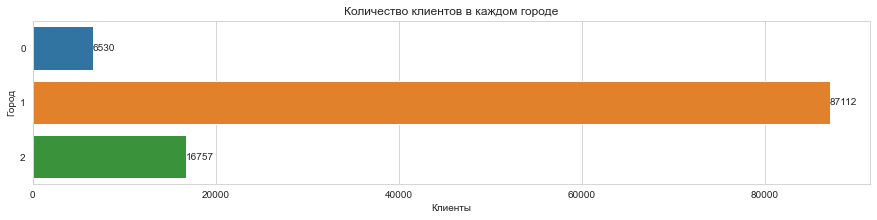

In [26]:
result = full.groupby('plant_city')['client_id'].nunique().rename('clients_count').reset_index()

plt.figure(figsize=(15,3))
g = sns.barplot(y="plant_city", x="clients_count", data=result, orient='h')
g.set_title("Количество клиентов в каждом городе")
g.set_xlabel('Клиенты')
g.set_ylabel('Город')
for p in g.patches:
    width = p.get_width()   
    g.text(width + 1, p.get_y() + p.get_height() / 2, '{:.0f}'.format(width), ha = 'left', va = 'center') 
plt.show()
del_vars()

Большинство клиентов сделали покупки в городе 1 (Other). На втором месте город 2 (Санкт-Петербург).

Посмотрим на количество магазинов в каждом городе.

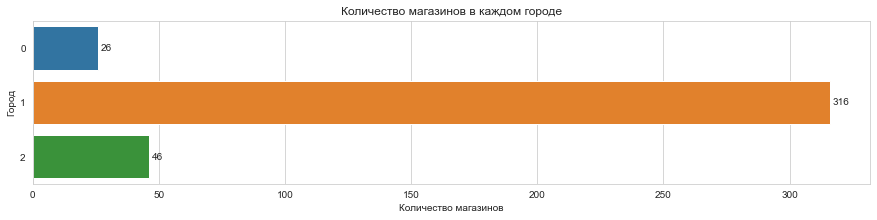

In [27]:
result = full.groupby('plant_city')['plant'].nunique().rename('plants_count').reset_index()

plt.figure(figsize=(15,3))
g = sns.barplot(y="plant_city", x="plants_count", data=result, orient='h')
g.set_title("Количество магазинов в каждом городе")
g.set_xlabel('Количество магазинов')
g.set_ylabel('Город')
for p in g.patches:
    width = p.get_width()   
    g.text(width + 1, p.get_y() + p.get_height() / 2, '{:.0f}'.format(width), ha = 'left', va = 'center') 
plt.show()
del_vars()

Количество магазинов в городах соотносится с количеством клиентов. Большинство магазинов находятся в городе 1 (Other). На втором месте город 2 (Санкт-Петербург).

Также будет полезно посмотреть на соотношение магазинов по типам в каждом городе.

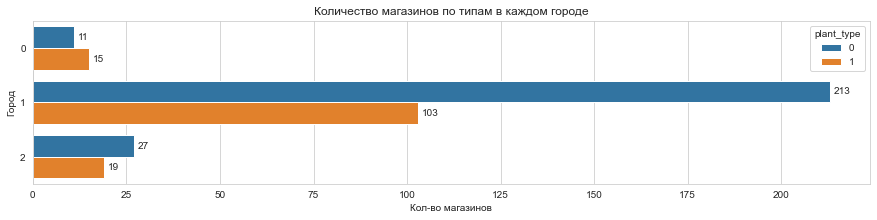

In [28]:
result = full.groupby(['plant_city', 'plant_type'])['plant'].nunique().rename('plants_count').reset_index()

plt.figure(figsize=(15,3))
g = sns.barplot(y="plant_city", x="plants_count", hue='plant_type', data=result, orient='h')
g.set_title("Количество магазинов по типам в каждом городе")
g.set_xlabel('Кол-во магазинов')
g.set_ylabel('Город')
for p in g.patches:
    width = p.get_width()   
    g.text(width + 1, p.get_y() + p.get_height() / 2, '{:.0f}'.format(width), ha = 'left', va = 'center') 
plt.show()
del_vars()

In [29]:
full = full.drop(columns='plant_city')

### Признак plant (id магазина)

Посмотрим на различные данные по магазинам.

In [30]:
tmp = full.groupby(['plant', 'plant_type', 'chq_id'])['sales_sum'].sum().reset_index()
result = tmp.groupby(['plant', 'plant_type'])['sales_sum'].agg(['count','sum','min','max','mean','median']).reset_index()

Суммарное количество покупок по магазинам

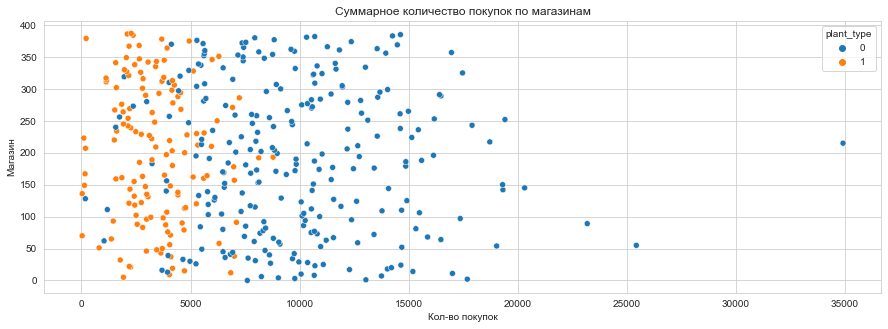

In [31]:
plt.figure(figsize=(15,5))
g = sns.scatterplot(y="plant", x="count", hue='plant_type', data=result)
g.set_title("Суммарное количество покупок по магазинам")
g.set_xlabel('Кол-во покупок')
g.set_ylabel('Магазин')
plt.show()

_Выводы:_
    
* _В магазинах типа 1 совершается меньше покупок, чем в магазинах типа 0._
* _В обоих типах магазинов есть непопулярные магазины, в которых совершено всего несколько сотен покупок._
* _Среди магазинов типа 0 есть аномальные магазины, в которых совершено очень большое количество покупок._

Посмотрим на непопулярные магазины:

In [32]:
some_plants = list(result[result['count']<150]['plant'])
print('Примеры непопулярных магазинов: {}'.format(some_plants))
print('-'*40)
for plant in some_plants:
    print(f'Магазин {plant}')
    print('Первая дата покупки: {}'.format(full[full.plant==plant]['chq_date'].min()))
    print('Последняя дата покупки: {}'.format(full[full.plant==plant]['chq_date'].max()))
    print('Количество клиентов, совершивших покупки: {}'.format(full[full.plant==plant]['client_id'].nunique()))
    print('Количество совершенных покупок: {}'.format(full[full.plant==plant]['chq_id'].nunique()))
    print('-'*40)

Примеры непопулярных магазинов: [70, 136, 149, 223]
----------------------------------------
Магазин 70
Первая дата покупки: 2016-10-04 00:00:00
Последняя дата покупки: 2016-10-14 00:00:00
Количество клиентов, совершивших покупки: 24
Количество совершенных покупок: 30
----------------------------------------
Магазин 136
Первая дата покупки: 2017-10-02 00:00:00
Последняя дата покупки: 2017-10-04 00:00:00
Количество клиентов, совершивших покупки: 24
Количество совершенных покупок: 33
----------------------------------------
Магазин 149
Первая дата покупки: 2017-09-25 00:00:00
Последняя дата покупки: 2017-10-04 00:00:00
Количество клиентов, совершивших покупки: 66
Количество совершенных покупок: 134
----------------------------------------
Магазин 223
Первая дата покупки: 2017-09-25 00:00:00
Последняя дата покупки: 2017-10-04 00:00:00
Количество клиентов, совершивших покупки: 65
Количество совершенных покупок: 105
----------------------------------------


Посмотрим выборочно на клиентов, сделавших покупки в данных магазинах.

In [33]:
some_clients = list(full[full['plant']==70]['client_id'].unique())
for client in some_clients:
    print('Количество покупок, совершенных клиентом {}: {}'.format(client, full[full.client_id==client]['chq_id'].nunique()))

Количество покупок, совершенных клиентом 87172: 6
Количество покупок, совершенных клиентом 98881: 11
Количество покупок, совершенных клиентом 21288: 13
Количество покупок, совершенных клиентом 15467: 22
Количество покупок, совершенных клиентом 49656: 28
Количество покупок, совершенных клиентом 51794: 2
Количество покупок, совершенных клиентом 20199: 11
Количество покупок, совершенных клиентом 54466: 2
Количество покупок, совершенных клиентом 68837: 8
Количество покупок, совершенных клиентом 33199: 99
Количество покупок, совершенных клиентом 54260: 43
Количество покупок, совершенных клиентом 44465: 134
Количество покупок, совершенных клиентом 78119: 7
Количество покупок, совершенных клиентом 98531: 18
Количество покупок, совершенных клиентом 98538: 18
Количество покупок, совершенных клиентом 35919: 5
Количество покупок, совершенных клиентом 41424: 63
Количество покупок, совершенных клиентом 96892: 19
Количество покупок, совершенных клиентом 95424: 6
Количество покупок, совершенных клиен

_Выводы:_
* _В данных присутствуют магазины с информацией за очень короткий период и с очень маленьким количеством покупок._
* _В данных присутствуют клиенты, совершившие очень маленькое количество покупок._

Посмотрим на магазины с аномально высоким количеством покупок:

In [34]:
some_plants = list(result[result['count']>25000]['plant'])
print('Примеры непопулярных магазинов: {}'.format(some_plants))
print('-'*40)
for plant in some_plants:
    print(f'Магазин {plant}')
    print('Первая дата покупки: {}'.format(full[full.plant==plant]['chq_date'].min()))
    print('Последняя дата покупки: {}'.format(full[full.plant==plant]['chq_date'].max()))
    print('Количество клиентов, совершивших покупки: {}'.format(full[full.plant==plant]['client_id'].nunique()))
    print('Количество совершенных покупок: {}'.format(full[full.plant==plant]['chq_id'].nunique()))
    print('-'*40)

Примеры непопулярных магазинов: [55, 215]
----------------------------------------
Магазин 55
Первая дата покупки: 2016-10-04 00:00:00
Последняя дата покупки: 2017-10-04 00:00:00
Количество клиентов, совершивших покупки: 1746
Количество совершенных покупок: 25438
----------------------------------------
Магазин 215
Первая дата покупки: 2016-10-04 00:00:00
Последняя дата покупки: 2017-10-04 00:00:00
Количество клиентов, совершивших покупки: 2140
Количество совершенных покупок: 34916
----------------------------------------


В данных не замечено ничего необычного. Посмотрим на покупки в этих магазинах в разрезе клиентов.

In [35]:
tmp = full.groupby(['plant', 'plant_type', 'client_id', 'chq_id'])['sales_sum'].sum().reset_index()
tmp2 = tmp.groupby(['plant', 'plant_type', 'client_id'])['sales_sum'].agg(['sum', 'count']).reset_index()
tmp2 = tmp2[tmp2.plant==55]

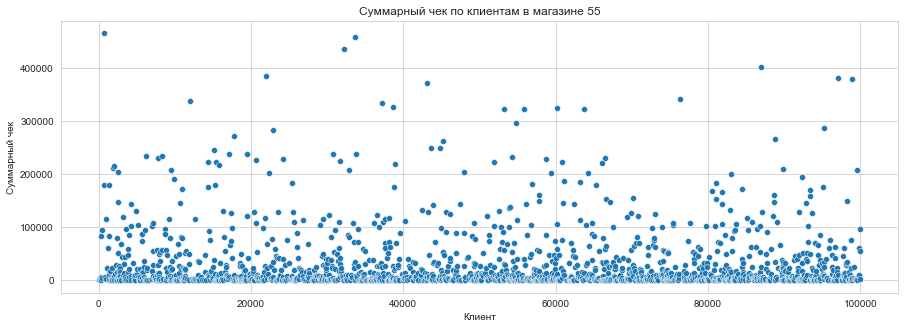

In [36]:
plt.figure(figsize=(15,5))
g = sns.scatterplot(x="client_id", y="sum", data=tmp2)
g.set_title("Суммарный чек по клиентам в магазине 55")
g.set_xlabel('Клиент')
g.set_ylabel('Суммарный чек')
plt.show()

Посмотрим на клиентов в магазине 55, сделавших всего покупок на сумму более 400 000.

In [37]:
some_clients = list(tmp2[(tmp2['plant']==55) & (tmp2['sum']>400000)]['client_id'].unique())
print('Примеры активных клиентов в магазине 55: {}'.format(some_clients))

Примеры активных клиентов в магазине 55: [682, 32138, 33677, 86954]


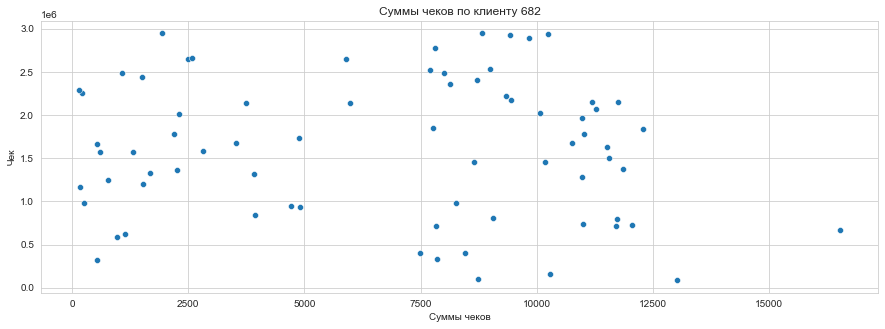

In [38]:
plt.figure(figsize=(15,5))
g = sns.scatterplot(y="chq_id", x="sales_sum", data=tmp[tmp.client_id==682])
g.set_title("Суммы чеков по клиенту 682")
g.set_xlabel('Суммы чеков')
g.set_ylabel('Чек')
plt.show()
del_vars()

В данных не замечено ничего необычного. Клиент совершает покупки на разные суммы, в том числе, довольно часто на крупные.

_Выводы:_
* _В данных присутствуют популярные магазины с очень большим количеством покупок._
* _В данных присутствуют клиенты, совершившие покупки на очень большую общую сумму._

## 2.3. Данные о клиентах

Оставшиеся данные о клиентах состоят из сведений о поле и дате рождения. Эти сведения, скорее всего, были заполнены самими клиентами. Поэтому стоит попробовать проверить их достоверность.

### Признак gender (пол клиента)

Посмотрим на соотношение клиентов по полу.

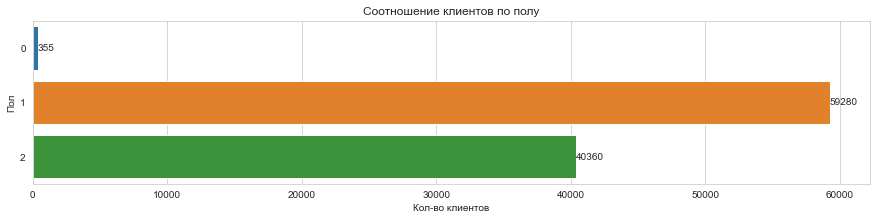

In [39]:
result = full.groupby(['gender'])['client_id'].nunique().rename('gender_count').reset_index()

plt.figure(figsize=(15,3))
g = sns.barplot(y="gender", x="gender_count", data=result, orient='h')
g.set_title("Соотношение клиентов по полу")
g.set_xlabel('Кол-во клиентов')
g.set_ylabel('Пол')
for p in g.patches:
    width = p.get_width()   
    g.text(width + 1, p.get_y() + p.get_height() / 2, '{:.0f}'.format(width), ha = 'left', va = 'center') 
plt.show()
# del_vars()

Соотношение полов в выборке (~ 60% / 40%) отличается от соотношения полов в России (~ 50% / 50%).

Посмотрим на общие средний чек и среднее количество покупок по каждому полу.

In [40]:
tmp = full.groupby(['gender', 'chq_id', 'client_id'])['sales_sum'].sum().rename('chq_sum').reset_index()
tmp2 = tmp.groupby(['gender', 'client_id'])['chq_sum'].agg(['count','mean']).reset_index()
result = tmp2.groupby(['gender']).agg({'count':'median','mean':'mean'}).reset_index()
result

,gender,count,mean
0,0,13,1661.718140
1,1,18,1438.185669
2,2,20,1486.582153


Средний чек (столбец mean) практически не отличается у обоих полов. Среднее количество покупок (столбец count) отличается на 10%.

Посмотрим на распределение значения среднего чека и количества покупок для каждого пола.

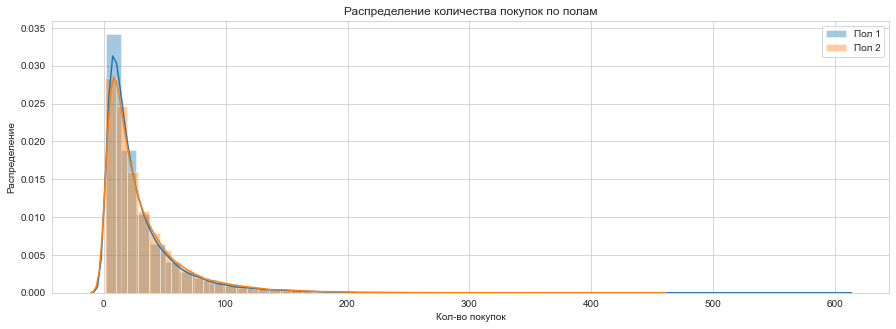

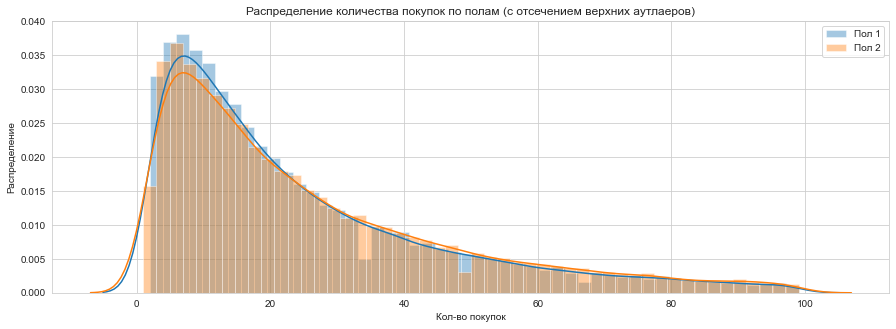

In [41]:
plt.figure(figsize=(15,5))

result = tmp2[tmp2.gender==1]
g = sns.distplot(result['count'], label='Пол 1')

result = tmp2[tmp2.gender==2]
g = sns.distplot(result['count'], label='Пол 2')

g.set_title("Распределение количества покупок по полам")
g.set_xlabel('Кол-во покупок')
g.set_ylabel('Распределение')
g.legend()
plt.show()

plt.figure(figsize=(15,5))

result = tmp2[(tmp2.gender==1) & (tmp2['count']<100)]
g = sns.distplot(result['count'], label='Пол 1')

result = tmp2[(tmp2.gender==2) & (tmp2['count']<100)]
g = sns.distplot(result['count'], label='Пол 2')

g.set_title("Распределение количества покупок по полам (с отсечением верхних аутлаеров)")
g.set_xlabel('Кол-во покупок')
g.set_ylabel('Распределение')
g.legend()
plt.show()

Распределения по количеству покупок в целом похожи у обоих полов. Однако, для пола 1 доля количества покупок в диапазоне до ~25 несколько выше, затем ниже, чем у пола 2.

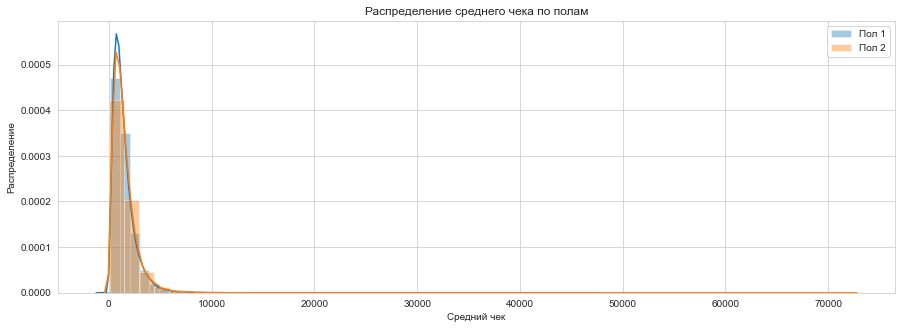

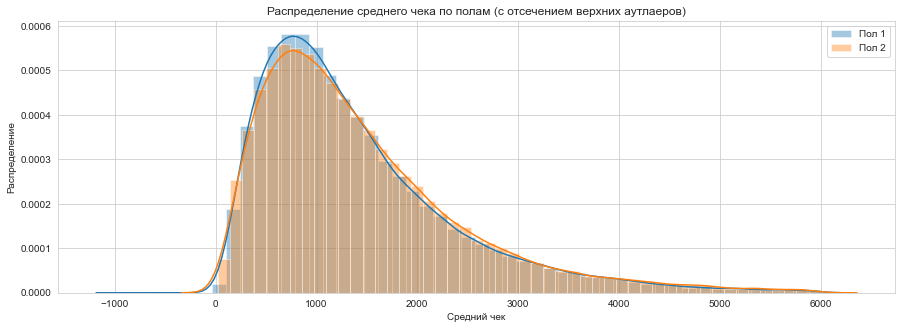

In [42]:
plt.figure(figsize=(15,5))

result = tmp2[tmp2.gender==1]
g = sns.distplot(result['mean'], label='Пол 1')

result = tmp2[tmp2.gender==2]
g = sns.distplot(result['mean'], label='Пол 2')

g.set_title("Распределение среднего чека по полам")
g.set_xlabel('Средний чек')
g.set_ylabel('Распределение')
g.legend()
plt.show()

plt.figure(figsize=(15,5))

result = tmp2[(tmp2.gender==1) & (tmp2['mean']<6000)]
g = sns.distplot(result['mean'], label='Пол 1')

result = tmp2[(tmp2.gender==2) & (tmp2['mean']<6000)]
g = sns.distplot(result['mean'], label='Пол 2')

g.set_title("Распределение среднего чека по полам (с отсечением верхних аутлаеров)")
g.set_xlabel('Средний чек')
g.set_ylabel('Распределение')
g.legend()
plt.show()

Распределения по среднему чеку в целом похожи у обоих полов. Однако, для пола 1 доля средних чеков на сумму до ~1500 несколько выше, затем ниже, чем у пола 2.

_Выводы:_
* _Существенных различий в покупательской активности клиентов разного пола не выявлено. С учетом того, что данный признак может содержать недостоверную информацию, лучшим решением будет не использовать его._

In [43]:
full = full.drop(columns='gender')
del_vars()

### Признак birthyear (год рождения клиента)

Посмотрим на количество клиентов по году рождения (год рождения 1899 указан для клиентов с неизвестными данными).

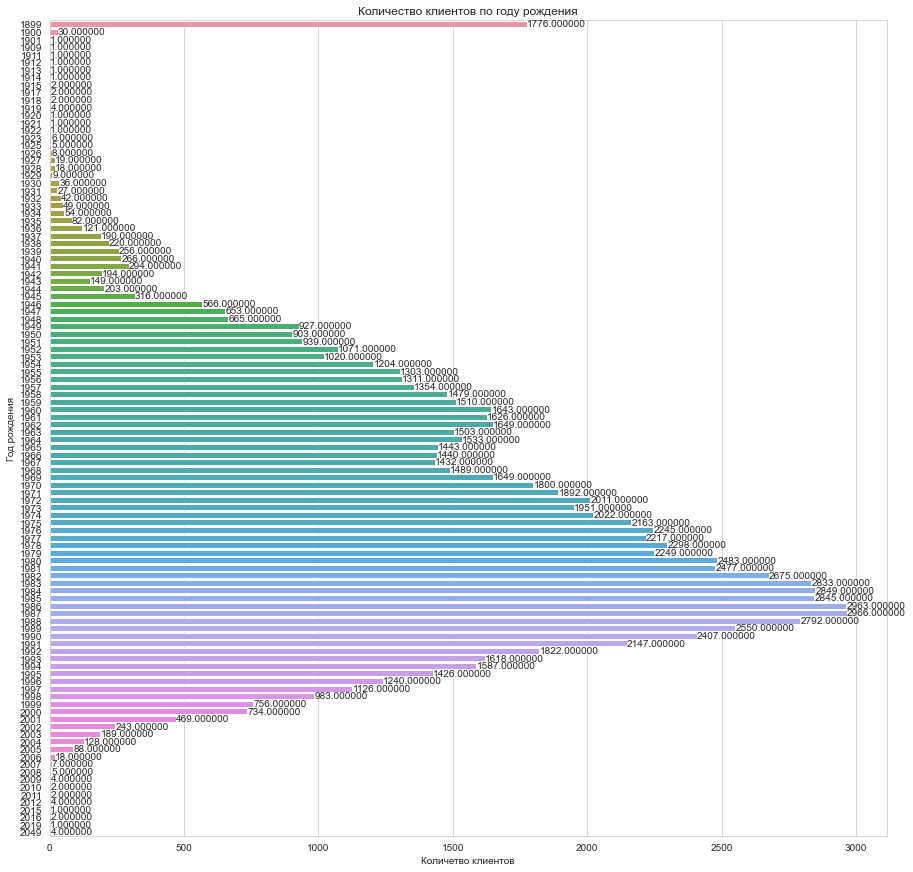

In [44]:
result = full.groupby(['birthyear'])['client_id'].nunique().rename('birthyear_count').reset_index()

plt.figure(figsize=(15,15))
g = sns.barplot(y="birthyear", x="birthyear_count", data=result, orient='h')
g.set_title("Количество клиентов по году рождения")
g.set_xlabel('Количетво клиентов')
g.set_ylabel('Год рождения')
for p in g.patches:
    width = p.get_width()   
    g.text(width + 1, p.get_y() + p.get_height() / 2, '{:0f}'.format(width), ha = 'left', va = 'center') 
plt.show()

In [45]:
2016-1989

27

* Выборка содержит данные за период 2016-2017гг. Однако, в ней присутствуют клиенты, указавшие дату рождения из будущего: 2019 и 2049. 
* Достаточно много клиентов, указавших дату рождения в диапазоне 1998-2016 (0 - 18 лет). 
* Существуют 30 клиентов датой рождения 1900 (126 лет). Возможно, что указать дату рождения старше 1900 г. не позволил функционал приложения, в котором указывались данные клиентов.
* Выглядит подозрительно резкое уменьшение количества клиентов 1963-1968 г.р.

Посмотрим на общие средний чек и среднее количество покупок по каждой дате рождения.

In [46]:
tmp = full.groupby(['birthyear', 'chq_id', 'client_id'])['sales_sum'].sum().rename('chq_sum').reset_index()
tmp2 = tmp.groupby(['birthyear', 'client_id'])['chq_sum'].agg(['count','mean']).reset_index()
result = tmp2.groupby(['birthyear']).agg({'count':'median','mean':'mean'}).reset_index()

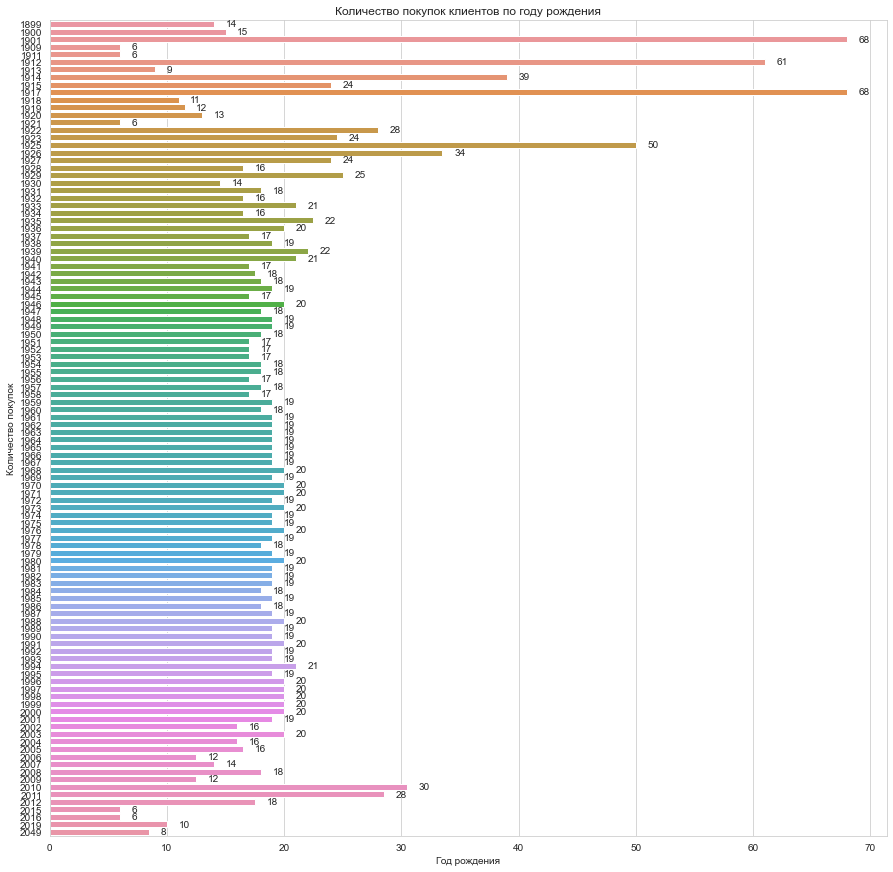

In [47]:
plt.figure(figsize=(15,15))
g = sns.barplot(y="birthyear", x="count", data=result, orient='h')
g.set_title("Количество покупок клиентов по году рождения")
g.set_xlabel('Год рождения')
g.set_ylabel('Количество покупок')
for p in g.patches:
    width = p.get_width()   
    g.text(width + 1, p.get_y() + p.get_height() / 2, '{:.0f}'.format(width), ha = 'left', va = 'center') 
plt.show()

* Средняя покупательская активность клиентов в "правдоподобном" возрасте 18-80 лет в целом не сильно отличается, и варьируется в диапазоне 17-20 покупок.
* Статистика по остальным  клиентам "скачет" из-за их относительно небольшого количества. Поэтому сложно сделать по ним какие-то достоверные выводы.

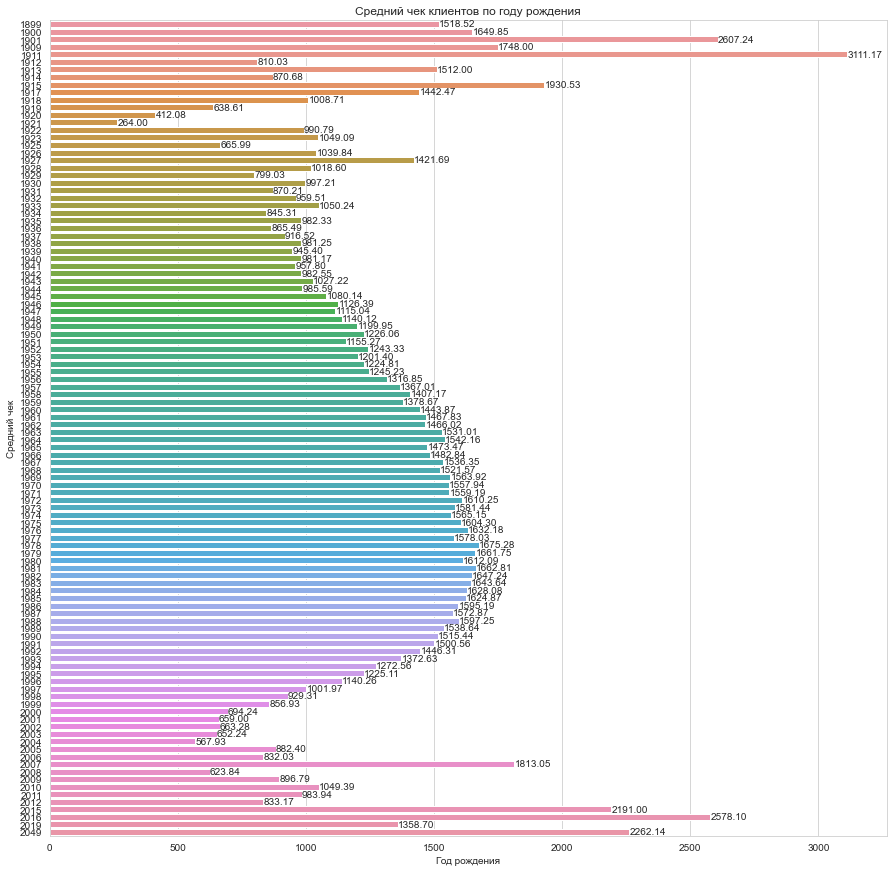

In [48]:
plt.figure(figsize=(15,15))
g = sns.barplot(y="birthyear", x="mean", data=result, orient='h')
g.set_title("Средний чек клиентов по году рождения")
g.set_xlabel('Год рождения')
g.set_ylabel('Средний чек')
for p in g.patches:
    width = p.get_width()   
    g.text(width + 1, p.get_y() + p.get_height() / 2, '{:.2f}'.format(width), ha = 'left', va = 'center') 
plt.show()

* Средний чек клиентов в "правдоподобном" возрасте 18-80 лет в целом не вызывает вопросов. Пенсионеры и очень молодые клиенты имеют небольшой доход, поэтому тратят меньше денег.
* Статистика по остальным клиентам "скачет" из-за их относительно небольшого количества. Поэтому сложно сделать по ним какие-то достоверные выводы.

_Выводы:_
* _Есть однозначные подтверждения того, что часть сведений по дате рождения клиентов недостоверная. С учетом того, что данный признак может содержать недостоверную информацию, лучшим решением будет не использовать его._

In [49]:
full = full.drop(columns='birthyear')
del_vars()

## 2.4. Данные о товарах

Данные о товарах представлены следующими признаками:
* material: id товара
* hier_level_1: Категория 1
* hier_level_2: Категория 2
* hier_level_3: Категория 2
* hier_level_4: Категория 2
* vendor: Производитель
* is_private_label: Признак собственной торговой марки
* is_alco: Признак алкогольной продукции

### Признак material

Из аналитики выше известно, что уникальных товаров на 1 меньше, чем записей по ним. Найдем "лишний" товар.

In [50]:
full_materials = full.material.unique()
material_materials = materials.material.unique()
list(set(material_materials) - set(full_materials))

[10721]

Посмотрим на "лишний" товар.

In [51]:
print('"Лишний" товар в materials')
display(materials[materials.material == 10721])
print('"Лишний" товар в full')
display(full[full.material == 10721])

"Лишний" товар в materials


,hier_level_1,hier_level_2,hier_level_3,hier_level_4,vendor,is_private_label,is_alco,material
17455,0,54,30,865,755,False,False,10721


"Лишний" товар в full


,chq_date,chq_position,sales_count,sales_sum,is_promo,client_id,material,plant,chq_id,price,hier_level_1,hier_level_2,hier_level_3,hier_level_4,vendor,is_private_label,is_alco,plant_type


"Лишний" товар отсутствует в full, поэтому никакие действия не требуются.

Посмотрим изменяется ли стоимость товаров в данных. Для этого ранее был добавлен дополнительный столбец price.

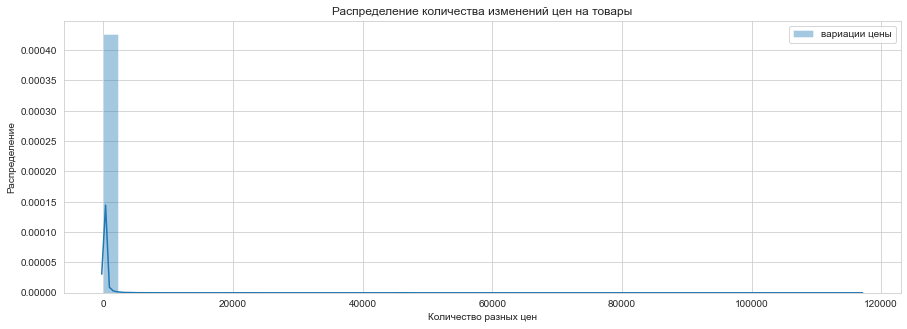

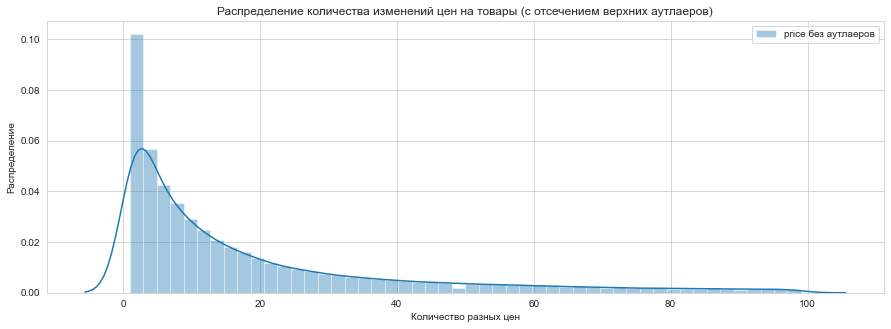

In [52]:
plt.figure(figsize=(15,5))

result = full.groupby(['material'])['price'].nunique().reset_index()
g = sns.distplot(result['price'], label='вариации цены')

g.set_title("Распределение количества изменений цен на товары")
g.set_xlabel('Количество разных цен')
g.set_ylabel('Распределение')
g.legend()
plt.show()

plt.figure(figsize=(15,5))

tmp = result[result['price']<100]
g = sns.distplot(tmp['price'], label='price без аутлаеров')

g.set_title("Распределение количества изменений цен на товары (с отсечением верхних аутлаеров)")
g.set_xlabel('Количество разных цен')
g.set_ylabel('Распределение')
g.legend()
plt.show()

В выборке много товаров, которые имеют больше одной цены. Посмотрим на их количество.

In [53]:
print(f'Всего товаров: {result.material.nunique()}')
print('Кол-во товаров с одной ценой: {} (доля в выборке {:.4f})'\
      .format(result[result.price == 1].shape[0],
              result[result.price == 1].shape[0]/result.material.nunique()))
for i in [1, 2, 10, 50, 100, 1000, 10000]:
    print('Кол-во товаров с более, чем {} разными ценами: {} (доля в выборке {:.4f})'\
      .format(i,
              result[result.price > i].shape[0],
              result[result.price > i].shape[0]/result.material.nunique()))

Всего товаров: 105608
Кол-во товаров с одной ценой: 11328 (доля в выборке 0.1073)
Кол-во товаров с более, чем 1 разными ценами: 94280 (доля в выборке 0.8927)
Кол-во товаров с более, чем 2 разными ценами: 87026 (доля в выборке 0.8240)
Кол-во товаров с более, чем 10 разными ценами: 57226 (доля в выборке 0.5419)
Кол-во товаров с более, чем 50 разными ценами: 22226 (доля в выборке 0.2105)
Кол-во товаров с более, чем 100 разными ценами: 12595 (доля в выборке 0.1193)
Кол-во товаров с более, чем 1000 разными ценами: 711 (доля в выборке 0.0067)
Кол-во товаров с более, чем 10000 разными ценами: 54 (доля в выборке 0.0005)


In [54]:
result.sort_values(by='price', ascending=False).iloc[0]['material']

40490

Посмотрим на ценовые показатели товара с самой варьируемой ценой, и 1000-го товара по варьируемости.

Показатели цены товара 40490:
     MIN:    1.00
     MAX:    117.91
     MEAN:   57.03
     MEDIAN: 55.88
     MODE:   56.89


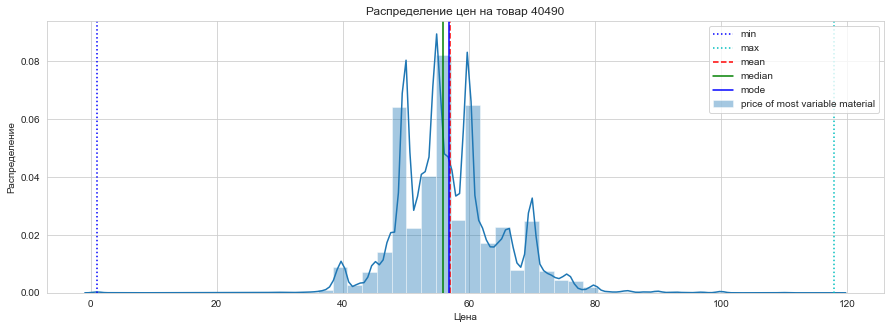

Показатели цены товара 36470:
     MIN:    191.51
     MAX:    562.24
     MEAN:   405.42
     MEDIAN: 399.93
     MODE:   440.08


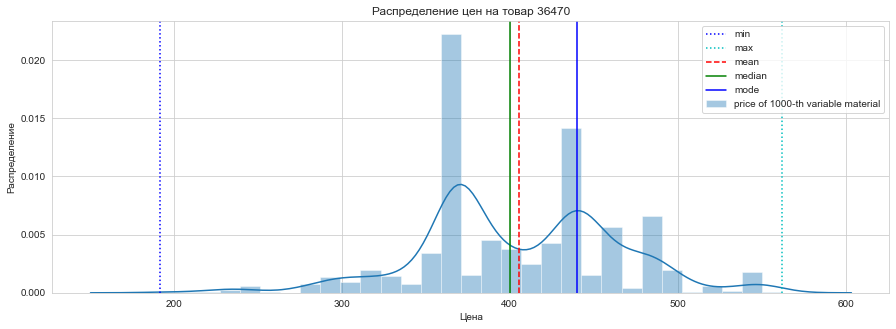

In [55]:
most_changeble_material = result.sort_values(by='price', ascending=False).iloc[0]['material']
not_most_changeble_material = result.sort_values(by='price', ascending=False).iloc[500]['material']

plt.figure(figsize=(15,5))

tmp = full[full.material==most_changeble_material][['sales_count', 'sales_sum', 'price']]
print(f'Показатели цены товара {most_changeble_material}:')
print(f'     MIN:    {tmp.price.min():.2f}')
print(f'     MAX:    {tmp.price.max():.2f}')
print(f'     MEAN:   {tmp.price.mean():.2f}')
print(f'     MEDIAN: {tmp.price.median():.2f}')
print(f'     MODE:   {mode(tmp.price):.2f}')

g = sns.distplot(tmp['price'], label='price of most variable material')
g.axvline(tmp.price.min(), color='b', linestyle=':', label='min')
g.axvline(tmp.price.max(), color='c', linestyle=':', label='max')
g.axvline(tmp.price.mean(), color='r', linestyle='--', label='mean')
g.axvline(tmp.price.median(), color='g', linestyle='-', label='median')
g.axvline(tmp.price.mode().get_values()[0], color='b', linestyle='-', label='mode')

g.set_title(f"Распределение цен на товар {most_changeble_material}")
g.set_xlabel('Цена')
g.set_ylabel('Распределение')
g.legend()
plt.show()

plt.figure(figsize=(15,5))

tmp = full[full.material==not_most_changeble_material][['sales_count', 'sales_sum', 'price']]
print(f'Показатели цены товара {not_most_changeble_material}:')
print(f'     MIN:    {tmp.price.min():.2f}')
print(f'     MAX:    {tmp.price.max():.2f}')
print(f'     MEAN:   {tmp.price.mean():.2f}')
print(f'     MEDIAN: {tmp.price.median():.2f}')
print(f'     MODE:   {mode(tmp.price):.2f}')
g = sns.distplot(tmp['price'], label='price of 1000-th variable material')
g.axvline(tmp.price.min(), color='b', linestyle=':', label='min')
g.axvline(tmp.price.max(), color='c', linestyle=':', label='max')
g.axvline(tmp.price.mean(), color='r', linestyle='--', label='mean')
g.axvline(tmp.price.median(), color='g', linestyle='-', label='median')
g.axvline(tmp.price.mode().get_values()[0], color='b', linestyle='-', label='mode')

g.set_title(f"Распределение цен на товар {not_most_changeble_material}")
g.set_xlabel('Цена')
g.set_ylabel('Распределение')
g.legend()
plt.show()

Посмотрим как изменятся ценовые показатели товара 40490 в отдельных магазинах.

Показатели цены товара 40490 в магазине 215.0:
     MIN:    10.11
     MAX:    93.69
     MEAN:   52.37
     MEDIAN: 52.90
Показатели цены товара 40490 в магазине 179:
     MIN:    29.15
     MAX:    93.66
     MEAN:   54.31
     MEDIAN: 54.91


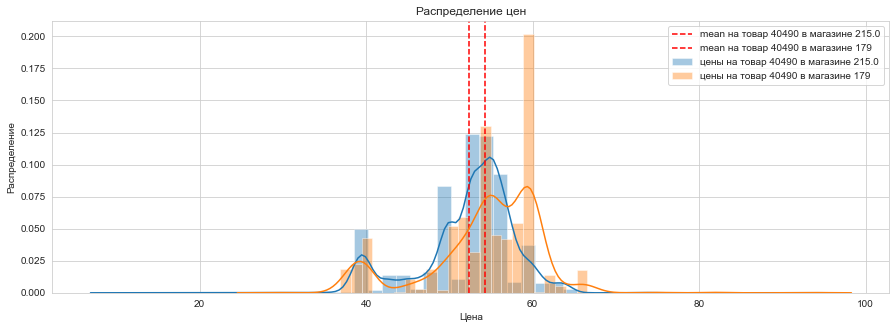

Показатели цены товара 36470 в магазине 215.0:
     MIN:    347.26
     MAX:    440.12
     MEAN:   405.35
     MEDIAN: 416.73
Показатели цены товара 36470 в магазине 179:
     MIN:    370.01
     MAX:    439.81
     MEAN:   389.90
     MEDIAN: 374.89


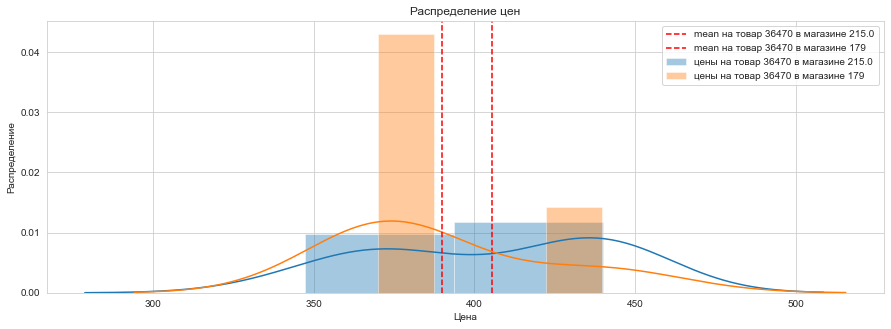

In [56]:
 for mat in [most_changeble_material, not_most_changeble_material]:
    plt.figure(figsize=(15,5))

    for i in [best_plant, 179]:
        tmp = full[(full.material==mat) & (full.plant==i)][['sales_count', 'sales_sum', 'price']]
        print(f'Показатели цены товара {mat} в магазине {i}:')
        print(f'     MIN:    {tmp.price.min():.2f}')
        print(f'     MAX:    {tmp.price.max():.2f}')
        print(f'     MEAN:   {tmp.price.mean():.2f}')
        print(f'     MEDIAN: {tmp.price.median():.2f}')

        g = sns.distplot(tmp['price'], label=f'цены на товар {mat} в магазине {i}')
        g.axvline(tmp.price.mean(), color='r', linestyle='--', label=f'mean на товар {mat} в магазине {i}')


    g.set_title(f"Распределение цен")
    g.set_xlabel('Цена')
    g.set_ylabel('Распределение')
    g.legend()
    plt.show()

_Выводы:_
* _Большинство товаров имеют гибкое ценообразование. Товары с неизменной ценой составляют всего 10% от всех товаров._
* _На примере нескольких товаров можно сделать предположение, что цена на товар, как правило, тяготеет к среднему значению и к значению ниже среднего (скидка)._
* _Имеет смысл мониторить в чеках клиентов изменение цены на товар относительно его средней и минимальной цены в магазине._

Посмотрим как распределяется минимальная, средняя и максимальная цены на товары в общем.

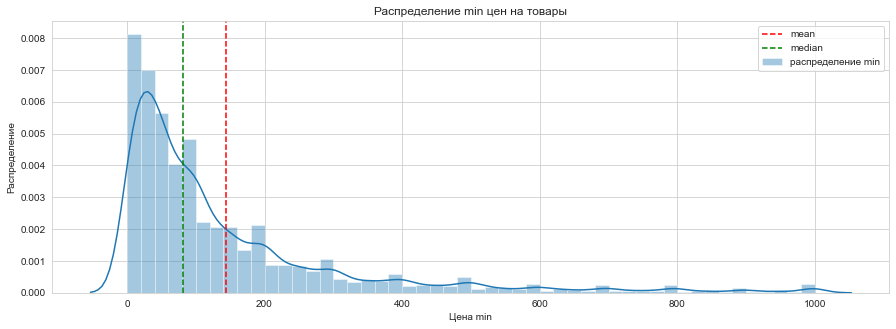

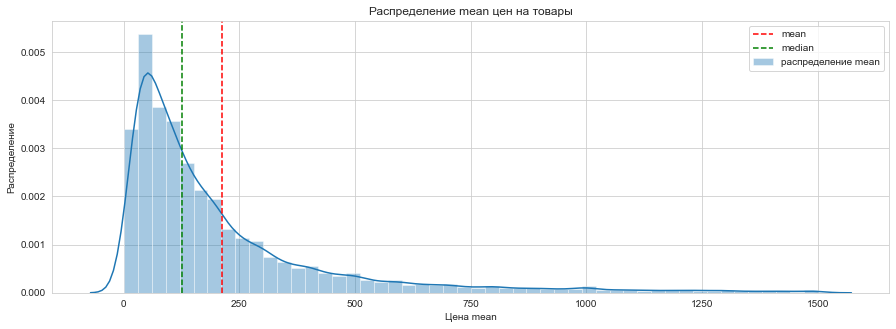

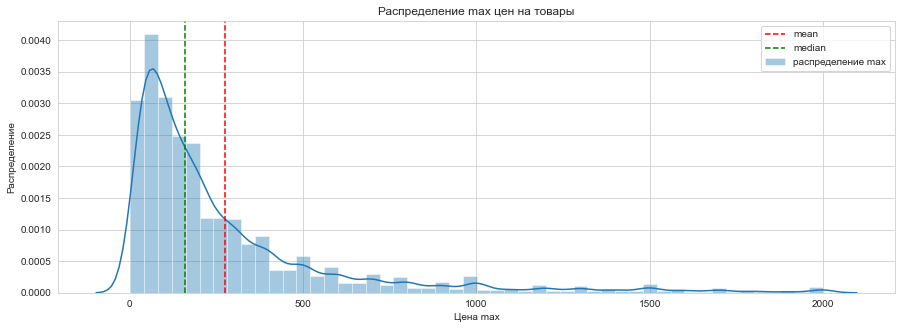

In [57]:
cut_outliers = [1000, 1500, 2000]
aggs = ['min', 'mean', 'max']
result = full.groupby(['material'])['price'].agg(aggs).reset_index()

for col, cut in zip(aggs, cut_outliers):
    plt.figure(figsize=(15,5))

    tmp = result[result[col]<cut]
    g = sns.distplot(tmp[col], label=f'распределение {col}')
    g.axvline(tmp[col].mean(), color='r', linestyle='--', label='mean')
    g.axvline(tmp[col].median(), color='g', linestyle='--', label='median')

    g.set_title(f"Распределение {col} цен на товары")
    g.set_xlabel(f'Цена {col}')
    g.set_ylabel('Распределение')
    g.legend()
    plt.show()
del_vars()

_Выводы:_
* _Минимальные, средние и максимальные значения цен на товар по большей части находятся в диапазоне невысоких цен. Дорогих товаров заметно меньше, чем дешевых._

Посмотрим как хорошо продаются товары в зависимости от цены в различных диапазонах.

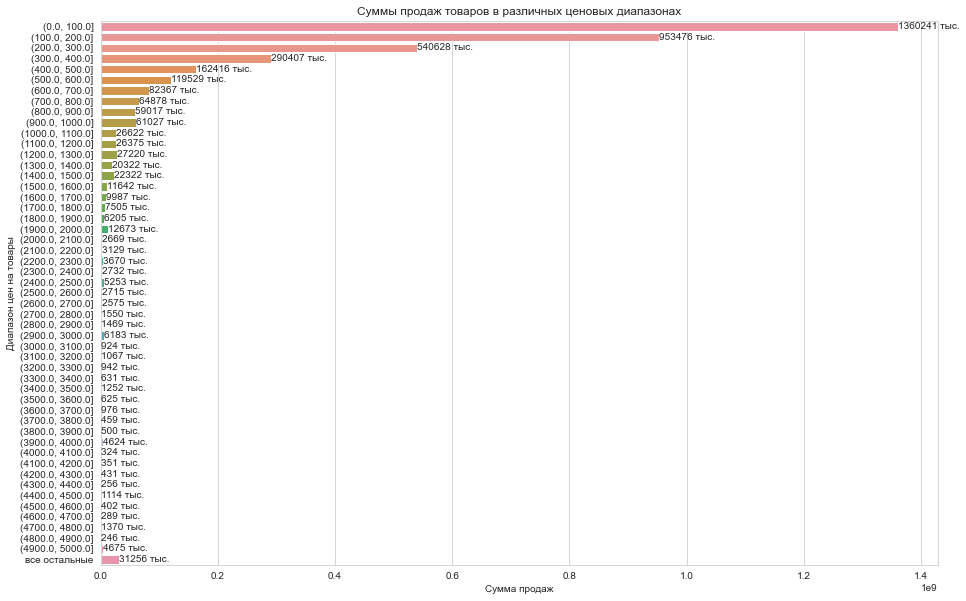

In [58]:
result = full.groupby(pd.cut(full.price, np.arange(0, full.price.max(), 100)))['sales_sum'].sum().reset_index()
threshold = 49
tmp = result.loc[threshold:, ['sales_sum']].sum()
result = result.loc[:threshold]
result.loc[threshold+1] = ['все остальные', tmp.sales_sum]

plt.figure(figsize=(15,10))
g = sns.barplot(y="price", x="sales_sum", data=result, orient='h')
g.set_title("Суммы продаж товаров в различных ценовых диапазонах")
g.set_xlabel('Сумма продаж')
g.set_ylabel('Диапазон цен на товары')
for p in g.patches:
    width = p.get_width()   
    g.text(width + 1, p.get_y() + p.get_height() / 2, '{:.0f} тыс.'.format(width/1000), ha = 'left', va = 'center') 
plt.show()

Товары с меньшей ценой наиболее популярны. Возможно, что есть дешевые товары, которые на самом деле продались мало, и наоборот. Сгруппируем цены на товары по общей сумме продаж в 10%-процентилях.

In [59]:
tmp2 = full.groupby(['price', 'material'])['sales_sum'].sum().reset_index().sort_values(by='sales_sum', ascending=False)
tmp2['percentile'] = None
total_sales = tmp2.sales_sum.sum()
percentile = total_sales/10

curr_percentile = 0
i = 1
for index, row in tmp2.iterrows():
    curr_percentile = curr_percentile + row['sales_sum']
    if curr_percentile >= percentile:
        i = i + 1
        curr_percentile = 0
    tmp2.at[index, 'percentile'] = i

Посмотрим на продажи товаров в 1-м, 2-м и 3-м процентилях (самых крупных по продажам).

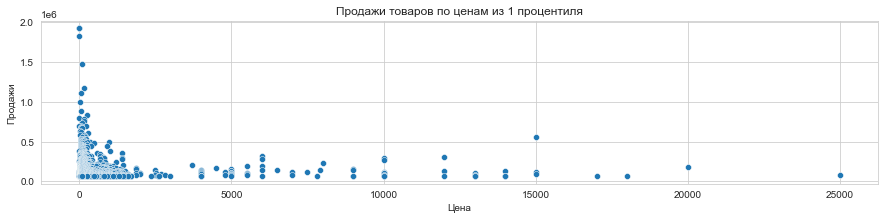

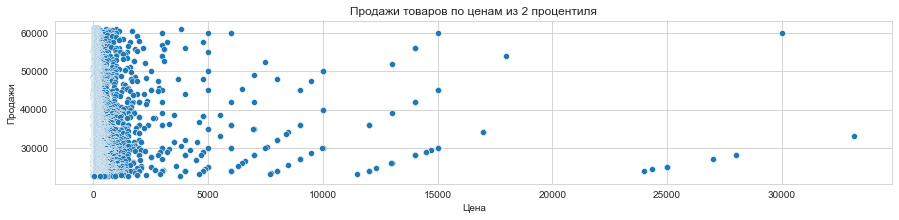

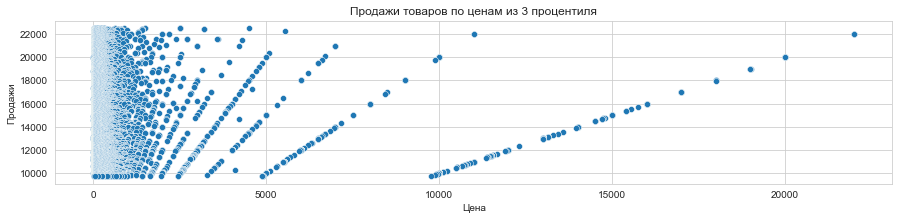

In [60]:
for i in [1,2,3]:
    plt.figure(figsize=(15,3))

    tmp3 = tmp2[tmp2.percentile == i]
    g = sns.scatterplot(x='price', y='sales_sum', data=tmp3)

    g.set_title(f"Продажи товаров по ценам из {i} процентиля")
    g.set_xlabel(f'Цена')
    g.set_ylabel('Продажи')

Из графиков видно, что есть дорогие товары, которые продались очень хорошо. И есть дешевые товары, не попавшие в 1-й процентиль (процентиль самых продаваемых товаров).

_Выводы_:
* _Товары с меньшей ценой наиболее популярны. Товары с ценой ниже 100 лидируют среди общих продаж. В топе продаж находятся товары с ценой до 400. Заметные продажи делают в том числе товары в диапазоне цен (400; 1500]. Остальные товары продаются заметно меньше._
* _Имеет смысл отсортировать цены на товары по суммарной цене продаж и затем сгруппировать по процентилям. Это поможет различать самые продаваемые товары с самой выгодной ценой (из 1 процентиля) и самые низкие по продажам (из 10 процентиля)._
* _Также имеет смысл сделать аналогичные группировки по количеству транзакций и мониторить частоту продаваемости каждого товара. Учитывать количество купленного товара в транзакции нецелесообразно, так как поштучные товары могут существенно увеличить частоту продаваемости. Но есть смысл для товара мониторить его модальное количество в чеке._
* _Данные показатели имеет смысл сгруппировать в целом по продажам._ 
* _Группировка для каждого магазина может дать недостоверный результат, так как есть магазины с  небольшим количеством данных (например, всего за 1 день)._
* _Группировка для каждого клиента может дать недостоверный результат. Есть клиенты с маленьким количеством покупок, и их товары нет смысла группировать на 10 процентилей._
* _Проверим наличие таких клиентов._

In [61]:
tmp = full.groupby('client_id')['material']\
            .nunique()\
            .rename('count')\
            .reset_index()\
            .sort_values(by='count', ascending=True)
bad_clients = tmp[tmp['count'] == tmp['count'].min()]
bad_clients

,client_id,count
45475,45477,1
69619,69622,1
84227,84231,1
18102,18102,1
21907,21907,1
74323,74326,1
11770,11770,1
27511,27512,1
22159,22159,1
15623,15623,1


В выборке есть клиенты, которые покупали только 1 товар. Посмотрим на транзакции одного из этих клиентов.

In [62]:
full[full.client_id==45477]

,chq_date,chq_position,sales_count,sales_sum,is_promo,client_id,material,plant,chq_id,price,hier_level_1,hier_level_2,hier_level_3,hier_level_4,vendor,is_private_label,is_alco,plant_type
1727082,2016-11-13,1,8.500000,84.07,True,45477,75428,87,1327115,9.890588,0,27,326,113,1007,False,False,1
1752813,2016-11-14,1,9.070312,90.07,True,45477,75428,50,1971959,9.930198,0,27,326,113,1007,False,False,1


Этот клиент сделал всего две покупки, и купил один и тот же товар. Это подтверждает, что группировка популярности товаров по клиентам нецелесообразна.

_Выводы:_
* _Имеет смысл мониторить популярность товаров конкретных клиентов не по процентилям, а только самый покупаемый. Для клиентов, покупавших всего 1 товар, этот товар и будет маркирован как самый покупаемый._

### Категории товара

In [63]:
del_vars()
print(f'Категорий уровня 1: {materials.hier_level_1.nunique()}')
print(f'Категорий уровня 2: {materials.hier_level_2.nunique()}')
print(f'Категорий уровня 3: {materials.hier_level_3.nunique()}')
print(f'Категорий уровня 4: {materials.hier_level_4.nunique()}')

Категорий уровня 1: 2
Категорий уровня 2: 60
Категорий уровня 3: 391
Категорий уровня 4: 2006


Категории товара также имеет смысл изучить по продаваемости.

### Признак hier_level_1 (категория 1)

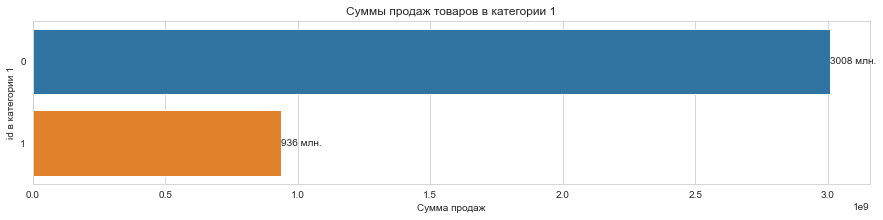

In [64]:
result = full.groupby('hier_level_1')['sales_sum'].sum().reset_index()

plt.figure(figsize=(15,3))
g = sns.barplot(y="hier_level_1", x="sales_sum", data=result, orient='h')
g.set_title("Суммы продаж товаров в категории 1")
g.set_xlabel('Сумма продаж')
g.set_ylabel('id в категории 1')
for p in g.patches:
    width = p.get_width()   
    g.text(width + 1, p.get_y() + p.get_height() / 2, '{:.0f} млн.'.format(width/1000000), ha = 'left', va = 'center') 
plt.show()

В категории 1 доход от товаров типа 0 больше, чем от товаров типа 1. Посмотрим на это соотношение для некоторых магазинов.

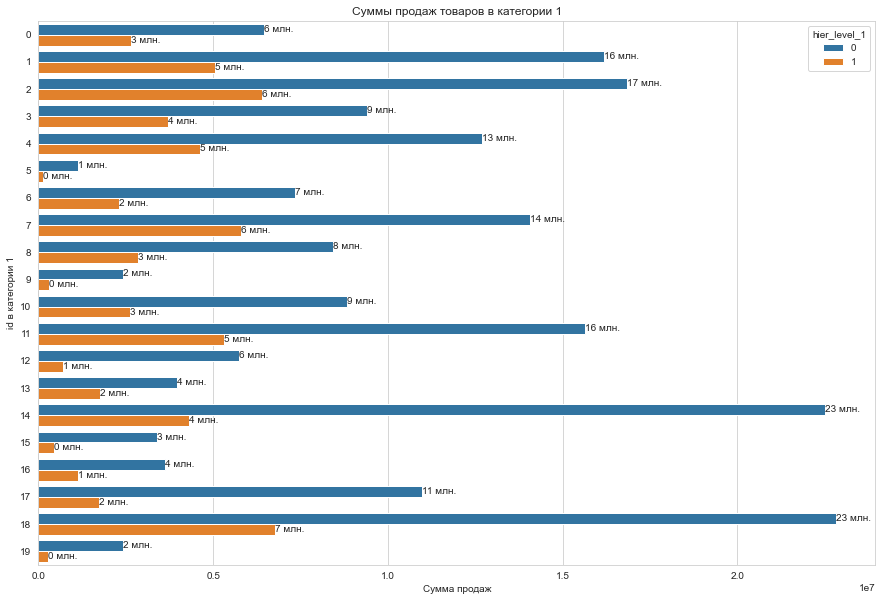

In [65]:
result = full.groupby(['hier_level_1', 'plant'])['sales_sum'].sum().reset_index()

plt.figure(figsize=(15,10))
g = sns.barplot(y="plant", x="sales_sum", hue='hier_level_1', data=result[result.plant<20], orient='h')
g.set_title("Суммы продаж товаров в категории 1")
g.set_xlabel('Сумма продаж')
g.set_ylabel('id в категории 1')
for p in g.patches:
    width = p.get_width()   
    g.text(width + 1, p.get_y() + p.get_height() / 2, '{:.0f} млн.'.format(width/1000000), ha = 'left', va = 'center') 
plt.show()

Действительно, товары категории 0 заметно доходнее, чем товары категории 1.
Посмотрим на частоту продаж.

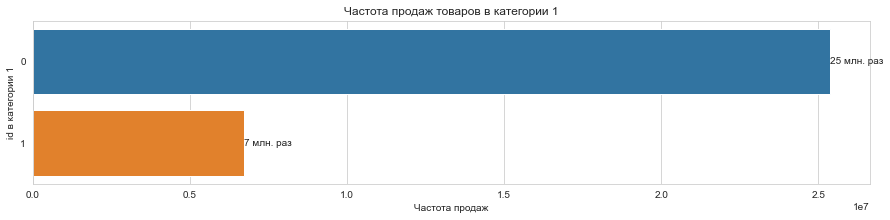

In [66]:
result = full.groupby('hier_level_1')['sales_sum'].count().reset_index()

plt.figure(figsize=(15,3))
g = sns.barplot(y="hier_level_1", x="sales_sum", data=result, orient='h')
g.set_title("Частота продаж товаров в категории 1")
g.set_xlabel('Частота продаж')
g.set_ylabel('id в категории 1')
for p in g.patches:
    width = p.get_width()   
    g.text(width + 1, p.get_y() + p.get_height() / 2, '{:.0f} млн. раз'.format(width/1000000), ha = 'left', va = 'center') 
plt.show()


_Выводы_:
* _Имеет смысл оставить данный признак и отслеживать какой тип в категории 1 является популярным и чаще продаваемым._
* _Группировка по магазинам не желательна. Группировка для каждого магазина может дать недостоверный результат, так как есть магазины с  небольшим количеством данных (например, всего за 1 день)._
* _Группировка для каждого клиента имеет смысл. Даже для клиента с маленьким количеством покупок будет полезно отслеживать, купил он больше товаров 1-го типа или 2-го типа в категории 1._

### Признак hier_level_2 (категория 2)

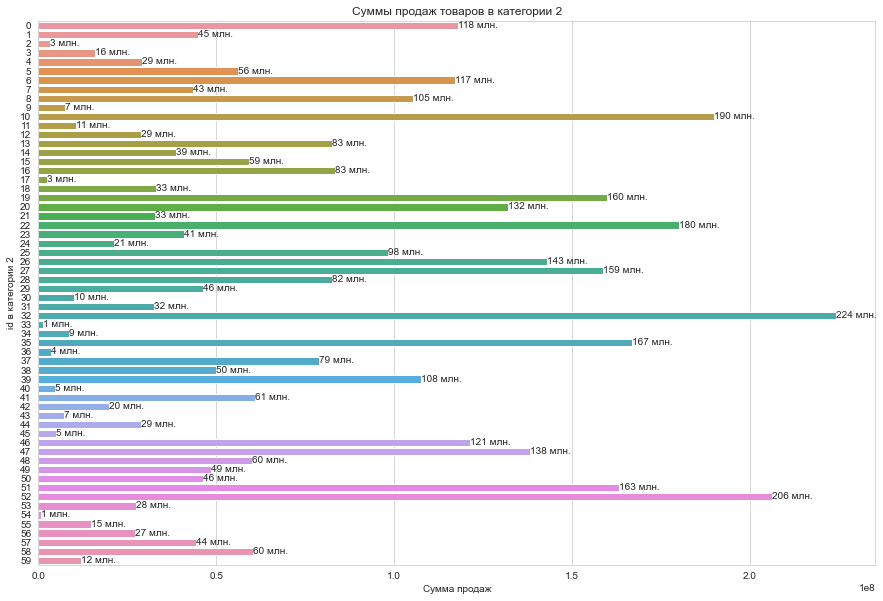

In [67]:
result = full.groupby('hier_level_2')['sales_sum'].sum().reset_index()

plt.figure(figsize=(15,10))
g = sns.barplot(y="hier_level_2", x="sales_sum", data=result, orient='h')
g.set_title("Суммы продаж товаров в категории 2")
g.set_xlabel('Сумма продаж')
g.set_ylabel('id в категории 2')
for p in g.patches:
    width = p.get_width()   
    g.text(width + 1, p.get_y() + p.get_height() / 2, '{:.0f} млн.'.format(width/1000000), ha = 'left', va = 'center') 
plt.show()

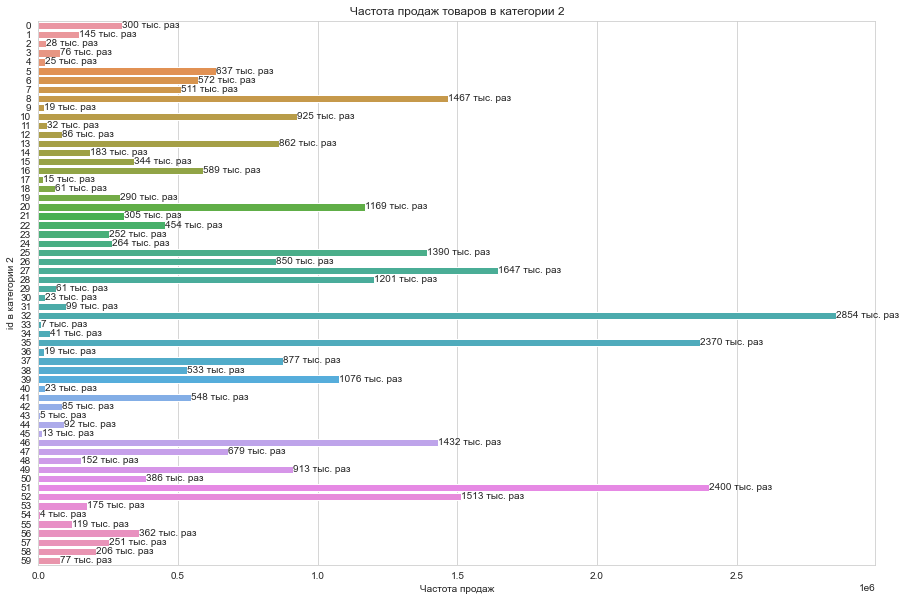

In [68]:
result = full.groupby('hier_level_2')['sales_sum'].count().reset_index()

plt.figure(figsize=(15,10))
g = sns.barplot(y="hier_level_2", x="sales_sum", data=result, orient='h')
g.set_title("Частота продаж товаров в категории 2")
g.set_xlabel('Частота продаж')
g.set_ylabel('id в категории 2')
for p in g.patches:
    width = p.get_width()   
    g.text(width + 1, p.get_y() + p.get_height() / 2, '{:.0f} тыс. раз'.format(width/1000), ha = 'left', va = 'center') 
plt.show()

_Выводы:_
* _Продажи  и частоты продаж в разных типах категории 2 существенно различаются, однако продаж в большинстве типов немного._
* _Имеет смысл мониторить продажи и частоту продаж в этой категории, разбив типы на 10%-квартили по количеству продаж и частоте продаж._
* _Для клиентов имеет смысл мониторить только самый популярный тип в категории 2._

### Признак hier_level_3 (категория 3)

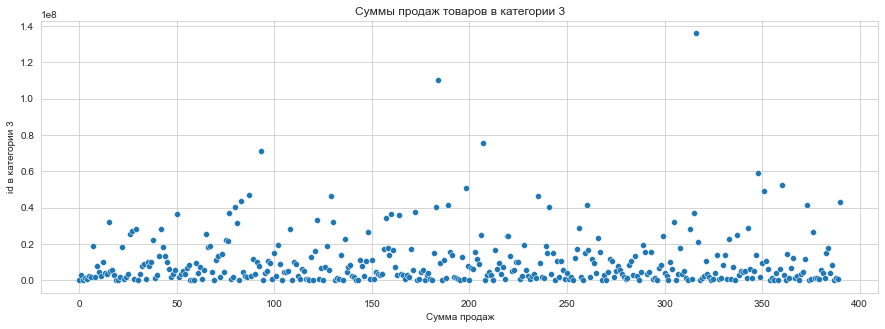

In [69]:
result = full.groupby('hier_level_3')['sales_sum'].sum().reset_index()

plt.figure(figsize=(15,5))
g = sns.scatterplot(x="hier_level_3", y="sales_sum", data=result)
g.set_title("Суммы продаж товаров в категории 3")
g.set_xlabel('Сумма продаж')
g.set_ylabel('id в категории 3')
plt.show()

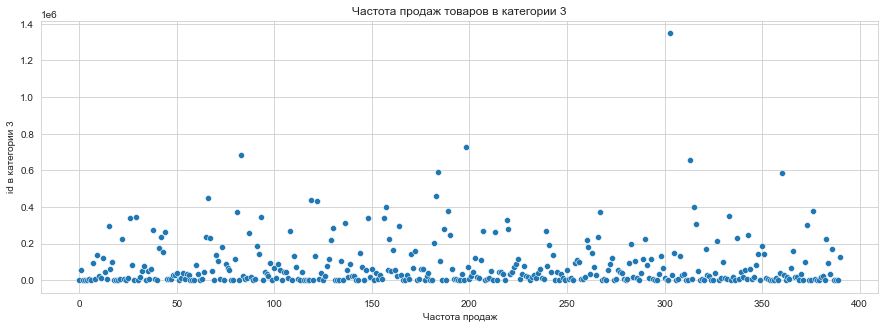

In [70]:
result = full.groupby('hier_level_3')['sales_sum'].count().reset_index()

plt.figure(figsize=(15,5))
g = sns.scatterplot(x="hier_level_3", y="sales_sum", data=result)
g.set_title("Частота продаж товаров в категории 3")
g.set_xlabel('Частота продаж')
g.set_ylabel('id в категории 3')
plt.show()

_Выводы:_
* _Продажи  и частоты продаж в разных типах категории 3 существенно различаются, однако продаж в большинстве типов немного._
* _Имеет смысл мониторить продажи и частоту продаж в этой категории, разбив типы на 10%-квартили по количеству продаж и частоте продаж._
* _Для клиентов имеет смысл мониторить только самый популярный тип в категории 3._

### Признак hier_level_4 (категория 4)

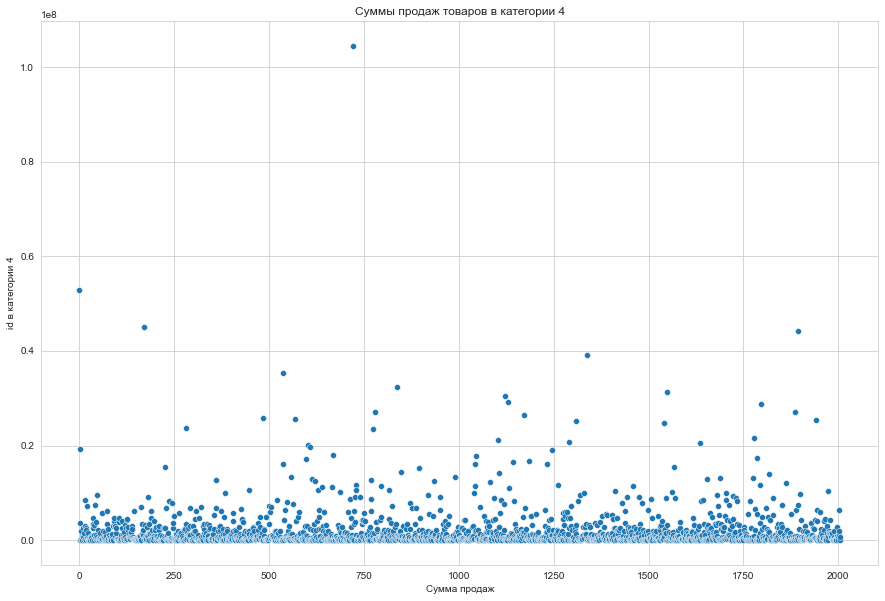

In [71]:
result = full.groupby('hier_level_4')['sales_sum'].sum().reset_index()

plt.figure(figsize=(15,10))
g = sns.scatterplot(x="hier_level_4", y="sales_sum", data=result)
g.set_title("Суммы продаж товаров в категории 4")
g.set_xlabel('Сумма продаж')
g.set_ylabel('id в категории 4')
plt.show()

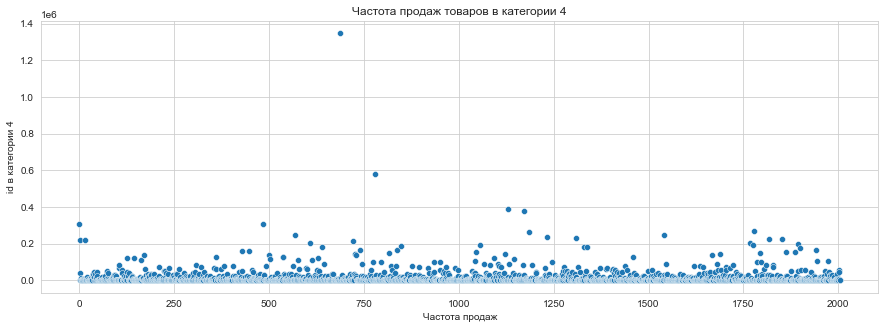

In [72]:
result = full.groupby('hier_level_4')['sales_sum'].count().reset_index()

plt.figure(figsize=(15,5))
g = sns.scatterplot(x="hier_level_4", y="sales_sum", data=result)
g.set_title("Частота продаж товаров в категории 4")
g.set_xlabel('Частота продаж')
g.set_ylabel('id в категории 4')
plt.show()

_Выводы:_
* _Продажи  и частоты продаж в разных типах категории 4 существенно различаются, однако продаж в большинстве типов немного._
* _Имеет смысл мониторить продажи и частоту продаж в этой категории, разбив типы на 10%-квартили по количеству продаж и частоте продаж._
* _Для клиентов имеет смысл мониторить только самый популярный тип в категории 4._

### Признак vendor

In [73]:
del_vars()
print(f'Уникальных производителей: {materials.vendor.nunique()}')

Уникальных производителей: 4185


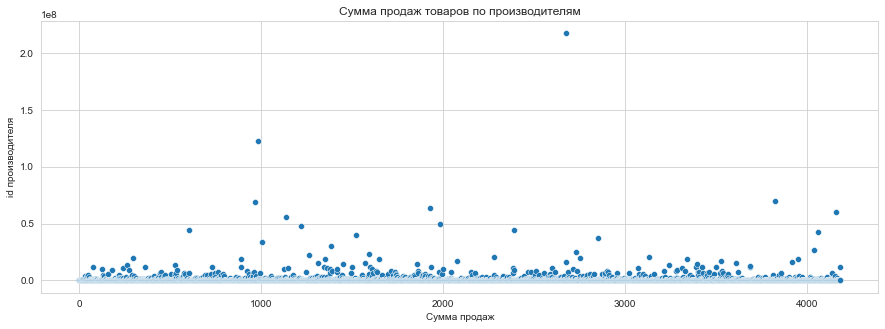

In [74]:
result = full.groupby('vendor')['sales_sum'].sum().reset_index()

plt.figure(figsize=(15,5))
g = sns.scatterplot(x="vendor", y="sales_sum", data=result)
g.set_title("Сумма продаж товаров по производителям")
g.set_xlabel('Сумма продаж')
g.set_ylabel('id производителя')
plt.show()

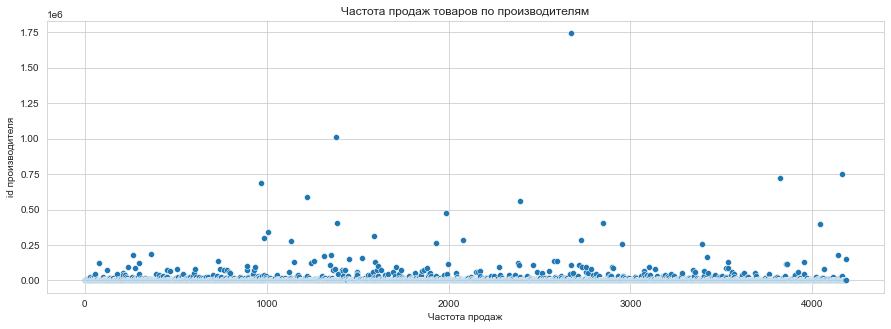

In [75]:
result = full.groupby('vendor')['sales_sum'].count().reset_index()

plt.figure(figsize=(15,5))
g = sns.scatterplot(x="vendor", y="sales_sum", data=result)
g.set_title("Частота продаж товаров по производителям")
g.set_xlabel('Частота продаж')
g.set_ylabel('id производителя')
plt.show()

В данных по производителям ситуация похожа на ситуацию в категориях. Это лишь идентификация товара по еще одной категории.

_Выводы:_
* _Продажи  и частоты продаж у производителей существенно различаются, однако продаж у большинства производителей немного._
* _Имеет смысл мониторить продажи и частоту продаж по производителям, разбив типы на 10%-квартили по количеству продаж и частоте продаж._
* _Для клиентов имеет смысл мониторить только самого популярного производителя._

Интересно также посмотреть на самого продаваемого и самого мало продаваемого производителя.

In [76]:
result = full.groupby('vendor')['sales_sum'].sum().reset_index()
best_vendor_sales = result[result.sales_sum==result.sales_sum.max()].iloc[0]
worst_vendor_sales = result[result.sales_sum==result.sales_sum.min()].iloc[0]
print(f'Лучший производитель: {best_vendor_sales.vendor}. Сумма продаж: {best_vendor_sales.sales_sum:.2f}')
print(f'Худший производитель: {worst_vendor_sales.vendor}. Сумма продаж: {worst_vendor_sales.sales_sum:.2f}')

result = full.groupby('vendor')['sales_sum'].count().reset_index()
best_vendor_counts = result[result.sales_sum==result.sales_sum.max()].iloc[0]
worst_vendor_counts = result[result.sales_sum==result.sales_sum.min()].iloc[0]
print(f'Лучший производитель: {best_vendor_counts.vendor}. Частота продаж: {best_vendor_counts.sales_sum:.2f}')
print(f'Худший производитель: {worst_vendor_counts.vendor}. Частота продаж: {worst_vendor_counts.sales_sum:.2f}')

Лучший производитель: 2674.0. Сумма продаж: 217202896.00
Худший производитель: 3567.0. Сумма продаж: 0.00
Лучший производитель: 2674. Частота продаж: 1742091.00
Худший производитель: 45. Частота продаж: 1.00


Имеется минимум один производитель, у которого всего 1 продажа. Посмотрим на него в транзакциях.

In [77]:
full[full.vendor==worst_vendor_counts.vendor]

,chq_date,chq_position,sales_count,sales_sum,is_promo,client_id,material,plant,chq_id,price,hier_level_1,hier_level_2,hier_level_3,hier_level_4,vendor,is_private_label,is_alco,plant_type
14390733,2017-03-04,15,0.583984,116.220001,False,37936,87713,55,1679582,199.012177,0,27,161,1688,45,False,False,0


Ничего необычного. Просто одна продажа по довольно небольшой цене. Однако, из транзакции можно заметить, что существуют товары с нецелым количеством проданных единиц. Вероятно, что это весовой товар, и единицей товара в этом случае является вес (килограмм, грамм и т.д.). Это подтверждает предположение, что мониторить частоту продаж эффективнее количеством транзакций, а не количеством проданных единиц.

Имеется минимум один производитель, у которого продано товаров на сумму 0. Посмотрим на него в транзакциях.

In [78]:
full[full.vendor==worst_vendor_sales.vendor]

,chq_date,chq_position,sales_count,sales_sum,is_promo,client_id,material,plant,chq_id,price,hier_level_1,hier_level_2,hier_level_3,hier_level_4,vendor,is_private_label,is_alco,plant_type
294234,2016-11-30,1,-1.0,-799.719971,False,62862,51968,186,1577883,799.719971,1,23,144,10,3567,False,False,0
294237,2016-11-30,11,1.0,799.719971,False,62862,51968,186,1737715,799.719971,1,23,144,10,3567,False,False,0
4337212,2016-12-03,23,1.0,799.119995,False,66026,51968,11,334161,799.119995,1,23,144,10,3567,False,False,0
4337219,2016-12-03,1,-1.0,-799.119995,False,66026,51968,11,1297987,799.119995,1,23,144,10,3567,False,False,0


По данному производителю имеются 4 транзакции. Причем 2 из них на отрицательные суммы и отрицательное количество. Это означает, что есть транзакции возврата товаров. 

_Выводы:_
* _Имеет смысл различать возвратные транзакции (покупку и возврат). Имеет смысл не включать их в агрегации по частоте продаж._

### Признаки is_private_label и is_alco

Данные признаки следует оставить, чтобы различать товары собственных марок и алкогольную продукцию. Но все таки проверим некоторую статистику. Посмотрим сколько всего производителей собственных марок и алкогольной продукции.

In [79]:
del_vars()
result = materials.groupby(['is_private_label'])['vendor'].nunique().reset_index()
display(result)
tmp = materials.groupby(['vendor'])['is_private_label'].nunique().reset_index()
result = tmp[tmp.is_private_label==2].shape[0]
print(f'Количество производителей, одновременно продающих/не продающих товары собственной марки: {result}')

,is_private_label,vendor
0,False,3526
1,True,1096


Количество производителей, одновременно продающих/не продающих товары собственной марки: 437


In [80]:
del_vars()
result = materials.groupby(['is_alco'])['vendor'].nunique().reset_index()
display(result)
tmp = materials.groupby(['vendor'])['is_alco'].nunique().reset_index()
result = tmp[tmp.is_alco==2].shape[0]
print(f'Количество производителей, одновременно продающих/не продающих алкоголь: {result}')

,is_alco,vendor
0,False,3928
1,True,323


Количество производителей, одновременно продающих/не продающих алкоголь: 66


Посмотрим на соотношение продаж по признаку is_private_label в составе общих продаж, в некоторых магазинах.

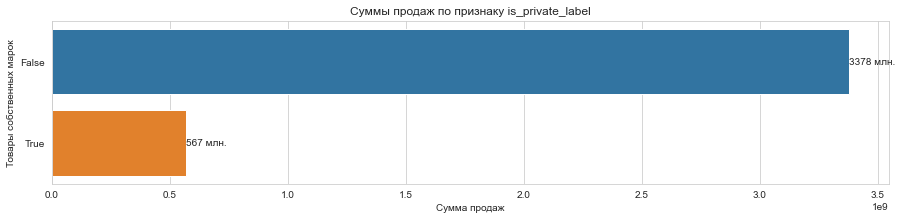

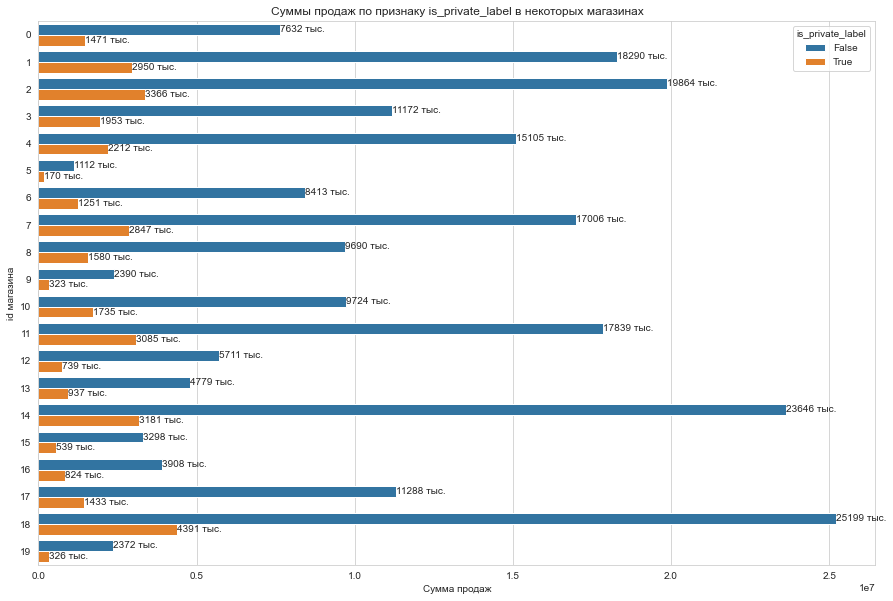

In [81]:
result = full.groupby(['is_private_label'])['sales_sum'].sum().reset_index()

plt.figure(figsize=(15,3))
g = sns.barplot(y="is_private_label", x="sales_sum",  data=result, orient='h')
g.set_title("Суммы продаж по признаку is_private_label")
g.set_xlabel('Сумма продаж')
g.set_ylabel('Товары собственных марок')
for p in g.patches:
    width = p.get_width()   
    g.text(width + 1, p.get_y() + p.get_height() / 2, '{:.0f} млн.'.format(width/1000000), ha = 'left', va = 'center') 
plt.show()

result = full.groupby(['is_private_label', 'plant'])['sales_sum'].sum().reset_index()

plt.figure(figsize=(15,10))
g = sns.barplot(y="plant", x="sales_sum", hue='is_private_label', data=result[result.plant<20], orient='h')
g.set_title("Суммы продаж по признаку is_private_label в некоторых магазинах")
g.set_xlabel('Сумма продаж')
g.set_ylabel('id магазина')
for p in g.patches:
    width = p.get_width()   
    g.text(width + 1, p.get_y() + p.get_height() / 2, '{:.0f} тыс.'.format(width/1000), ha = 'left', va = 'center') 
plt.show()

Товары собственной марки составляют лишь небольшую часть продаж в магазинах.

Посмотрим на соотношение продаж по признаку is_alco в составе общих продаж, в некоторых магазинах.

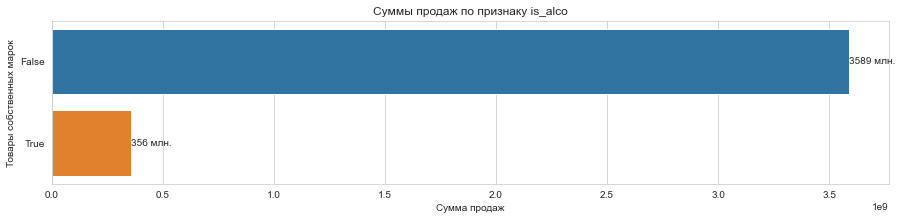

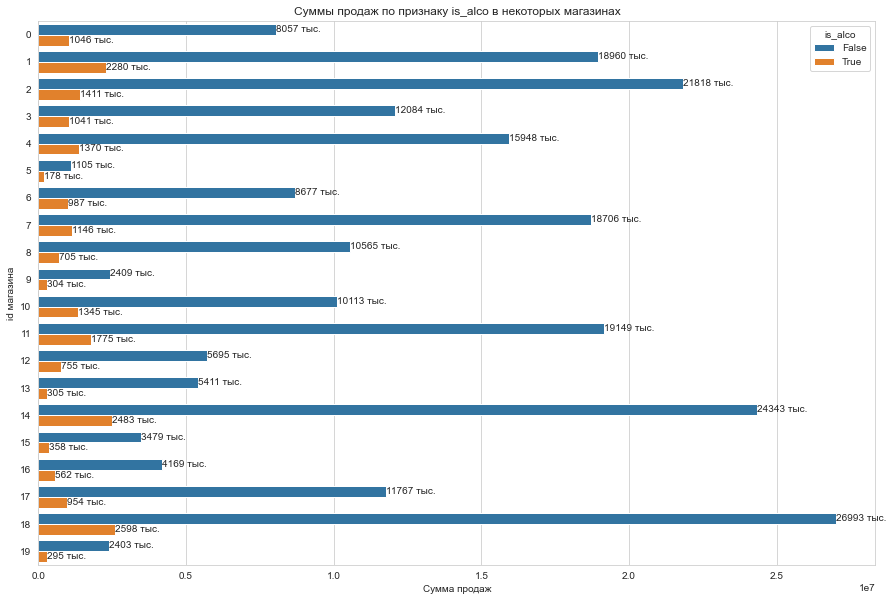

In [82]:
result = full.groupby(['is_alco'])['sales_sum'].sum().reset_index()

plt.figure(figsize=(15,3))
g = sns.barplot(y="is_alco", x="sales_sum",  data=result, orient='h')
g.set_title("Суммы продаж по признаку is_alco")
g.set_xlabel('Сумма продаж')
g.set_ylabel('Товары собственных марок')
for p in g.patches:
    width = p.get_width()   
    g.text(width + 1, p.get_y() + p.get_height() / 2, '{:.0f} млн.'.format(width/1000000), ha = 'left', va = 'center') 
plt.show()

result = full.groupby(['is_alco', 'plant'])['sales_sum'].sum().reset_index()

plt.figure(figsize=(15,10))
g = sns.barplot(y="plant", x="sales_sum", hue='is_alco', data=result[result.plant<20], orient='h')
g.set_title("Суммы продаж по признаку is_alco в некоторых магазинах")
g.set_xlabel('Сумма продаж')
g.set_ylabel('id магазина')
for p in g.patches:
    width = p.get_width()   
    g.text(width + 1, p.get_y() + p.get_height() / 2, '{:.0f} тыс.'.format(width/1000), ha = 'left', va = 'center') 
plt.show()

Товары алкогольной продукции составляют лишь небольшую часть продаж в магазинах.

# 3. Сохранение данных

Сохраним финальные данные в формате pickle для последующего использования.

In [83]:
path = str(workdir+'/data')
if not os.path.isdir(path):
    os.mkdir(path)
    print('Папка успешно создана!')
else:
    print('Папка уже существует')

Папка уже существует


In [84]:
full.to_pickle(path+'/full.pkl')
transactions.to_pickle(path+'/transactions.pkl')
clients.to_pickle(path+'/clients.pkl')
materials.to_pickle(path+'/materials.pkl')
plants.to_pickle(path+'/plants.pkl')